
# **TrendSpotter — Full Prototype** 
## by Group: Peaking
<br>

This notebook implements a complete **TrendSpotter** prototype:

**Core workflow**
1. Data Loading & Preprocessing – titles, tags, and publication dates.
2. Keyword & Hashtag Extraction – generate normalized tokens for trend tracking.
3. Trend Growth Analysis – compare activity in the last 30 days vs previous 30 days.
4. Top trends table + bar chart
5. Audience Segmentation – map tokens to verticals (e.g., beauty, haircare) and visualize distribution.
6. Decay Detection – identify peak activity and visualize decline phases for top 3 trend.

**Enhancements**

7. **Momentum Score** — engagement-weighted ranking
8. **Segment Drill-Down** for any trend
9. **DL Mode (Semantic Clustering)** — transformer embeddings + KMeans (fallback: TF-IDF)
10. Decay Forecasting (Optional) – project trend lifecycles using Holt-Winters exponential smoothing (statsmodels).



## Comment Enrichment Toggle

**Set `USE_COMMENTS` to `False`** to run the **video-only** pipeline (stable creator-side signals).

**Set `USE_COMMENTS` to `True`** to **enrich** with audience-side comments (sentiment, slang, echo detection).

> Default: `False` (recommended for competition backbone).  
> You can turn it on for the demo segment showing sentiment/slang insights.


In [3]:
USE_COMMENTS = True # set to True to include comments enrichment


## 0) Setup & Imports

In [5]:
import pandas as pd
import numpy as np
import re
import ast
import seaborn as sns
from datetime import timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import glob

# Optional imports (DL mode & forecasting)
try:
    from sentence_transformers import SentenceTransformer
    HAS_ST = True
except Exception:
    HAS_ST = False

try:
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    from sklearn.feature_extraction.text import TfidfVectorizer
    HAS_SK = True
except Exception:
    HAS_SK = False

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    HAS_SM = True
except Exception:
    HAS_SM = False

# Paths
DATA = "videos.csv"   # Change if your file path differs
OUT_DIR = Path("trendspotter_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("HAS_ST (SentenceTransformers):", HAS_ST)
print("HAS_SK (scikit-learn):", HAS_SK)
print("HAS_SM (statsmodels):", HAS_SM)
print("DATA path:", DATA)
print("Outputs ->", OUT_DIR)


HAS_ST (SentenceTransformers): True
HAS_SK (scikit-learn): True
HAS_SM (statsmodels): True
DATA path: videos.csv
Outputs -> trendspotter_outputs


### Language Detection & Translation


In [7]:
import warnings
from langdetect import detect

# English variants
ENGLISH_CODES = {"en", "en-us", "en-in", "en-gb"}

def detect_lang(text):
    try:
        return detect(text).lower()
    except Exception:
        return 'und'

def translate_to_en(text):
    # Try googletrans first
    try:
        from googletrans import Translator
        tr = Translator()
        return tr.translate(text, dest='en').text
    except Exception:
        pass
    # Fallback: transformers translation pipeline
    try:
        from transformers import pipeline
        trans = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')
        s = str(text); step = 400
        outs = [trans(s[i:i+step])[0]['translation_text'] for i in range(0, len(s), step)]
        return ' '.join(outs)
    except Exception:
        pass
    return text  # fallback to original

def maybe_translate(text):
    if not isinstance(text, str) or not text.strip():
        return text
    lang = detect_lang(text)
    if lang in ENGLISH_CODES or lang == 'und':
        return text
    try:
        return translate_to_en(text)
    except Exception as e:
        warnings.warn(f"Translation failed: {e}")
        return text


### Utilities: Language Detection & Translation (with fallbacks)


In [9]:
import sys, pkgutil, platform
print("Python exe  :", sys.executable)
print("Python ver  :", sys.version)
print("Platform    :", platform.platform())

# Where pip installs to (from this kernel)
import subprocess, shlex
subprocess.run(shlex.split(f'"{sys.executable}" -m pip -V'))

# Is sentence_transformers visible to THIS kernel?
try:
    import sentence_transformers
    from sentence_transformers import SentenceTransformer
    print("✅ Import OK:", sentence_transformers.__version__)
except Exception as e:
    print("❌ Import failed ->", repr(e))

Python exe  : C:\Users\lunwe\anaconda3\python.exe
Python ver  : 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Platform    : Windows-10-10.0.26100-SP0
✅ Import OK: 5.1.0


In [10]:
import os, sys, subprocess

# Force Transformers to skip TensorFlow/Flax so only PyTorch is used
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

# Install CPU-only PyTorch + pin protobuf + ST
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade",
                "torch", "--index-url", "https://download.pytorch.org/whl/cpu"], check=False)
subprocess.run([sys.executable, "-m", "pip", "install", "--upgrade",
                "sentence-transformers", "protobuf==4.25.3"], check=False)

# Remove ml-dtypes (often the culprit for the DType proto clash)
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "ml-dtypes"], check=False)

CompletedProcess(args=['C:\\Users\\lunwe\\anaconda3\\python.exe', '-m', 'pip', 'uninstall', '-y', 'ml-dtypes'], returncode=0)

In [11]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"    # don’t import TensorFlow
os.environ["TRANSFORMERS_NO_FLAX"] = "1"  # don’t import Flax/JAX

In [12]:
import sys, subprocess, shlex

# Clean out TF stack (safe if you don't need TF)
for pkg in ["tensorflow", "tensorflow-intel", "tensorflow-io-gcs-filesystem", "keras", "ml-dtypes"]:
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", pkg])

# CPU-only PyTorch
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade torch --index-url https://download.pytorch.org/whl/cpu'))

# Known-good pins (stable together)
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade protobuf==4.25.3'))
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade transformers==4.41.2'))
subprocess.run(shlex.split(f'"{sys.executable}" -m pip install --upgrade sentence-transformers==2.6.1'))


CompletedProcess(args=['C:\\Users\\lunwe\\anaconda3\\python.exe', '-m', 'pip', 'install', '--upgrade', 'sentence-transformers==2.6.1'], returncode=0)

In [13]:
from sentence_transformers import SentenceTransformer
print("ST import OK ✅")
model = SentenceTransformer("all-MiniLM-L6-v2")  # downloads the first time
print("Model loaded ✅")

ST import OK ✅


C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model loaded ✅


## 1) Load & Basic Clean

In [15]:

# Load
df = pd.read_csv(DATA)

# Ensure required fields exist
expected_cols = {
    "videoId","publishedAt","title","description","tags","topicCategories",
    "viewCount","likeCount","commentCount","defaultLanguage","defaultAudioLanguage","contentDuration"
}
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan

# Parse dates -> local timezone for grouping
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce", utc=True)
df = df.dropna(subset=["publishedAt"]).copy()
df["publishedAt_local"] = df["publishedAt"].dt.tz_convert("Asia/Kuala_Lumpur")

# Normalize text columns
def safe_str(x): return "" if pd.isna(x) else str(x)
for col in ["title","description","tags","topicCategories"]:
    df[col] = df[col].apply(safe_str)

# Ensure numeric engagement columns
for col in ["viewCount","likeCount","commentCount"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

df.head(3)


,kind,videoId,publishedAt,channelId,title,description,tags,defaultLanguage,defaultAudioLanguage,contentDuration,viewCount,likeCount,favouriteCount,commentCount,topicCategories,publishedAt_local
0,youtube#video,85806,2024-01-15 00:59:29+00:00,33807,Unlocking the Benefits of Face Masks for Skin ...,,,en-US,en-US,PT9S,72.0,0.0,0.0,0.0,"['https://en.wikipedia.org/wiki/Health', 'http...",2024-01-15 08:59:29+08:00
1,youtube#video,30556,2023-10-27 19:32:16+00:00,46650,Get ready for the Magic💚💜🤍💝✨ #hydration #glowi...,,,NaN,NaN,PT45S,257.0,7.0,0.0,0.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,2023-10-28 03:32:16+08:00
2,youtube#video,51771,2024-09-28 01:23:22+00:00,14346,#trending #makeup #beautymakeup #yslbeauty #lu...,,,NaN,en-US,PT19S,164.0,4.0,0.0,2.0,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,2024-09-28 09:23:22+08:00


## IDA (Initial Data Analysis)

In [17]:
# =========================
# IDA (sanity checks)
# =========================

print("Dataset shape:", df.shape)
print("\n Columns:", df.columns.tolist())

Dataset shape: (92759, 16)

 Columns: ['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration', 'viewCount', 'likeCount', 'favouriteCount', 'commentCount', 'topicCategories', 'publishedAt_local']


In [18]:
# --- Missing values ---
print("\n Missing values:")
display(df.isna().sum())


 Missing values:


kind                        0
videoId                     0
publishedAt                 0
channelId                   0
title                       0
description                 0
tags                        0
defaultLanguage         76974
defaultAudioLanguage    62803
contentDuration          1267
viewCount                   0
likeCount                   0
favouriteCount           1267
commentCount                0
topicCategories             0
publishedAt_local           0
dtype: int64

### Handling Missing Values

In [20]:
# =========================
# Data Cleaning Step
# =========================

# 1) Drop 'favouriteCount' column
if "favouriteCount" in df.columns:
    df = df.drop(columns=["favouriteCount"])
    print("✅ Removed column: favouriteCount")

# 2) Helper function for language detection
def safe_detect(text):
    try:
        if isinstance(text, str) and text.strip():
            return detect(text)
    except Exception:
        return "unknown"
    return "unknown"

# 3) Fill missing defaultLanguage and defaultAudioLanguage
for col in ["defaultLanguage", "defaultAudioLanguage"]:
    if col in df.columns:
        missing_mask = df[col].isna() | (df[col] == "")
        print(f"Filling {missing_mask.sum()} missing values in {col}...")
        df.loc[missing_mask, col] = (
            df.loc[missing_mask, ["title", "description"]]
              .apply(lambda r: safe_detect(str(r["title"]) + " " + str(r["description"])), axis=1)
        )

# 4) Quick check
print("\nAfter filling:")
print(df[["defaultLanguage","defaultAudioLanguage"]].isna().sum())
print(df[["defaultLanguage","defaultAudioLanguage"]].value_counts().head(10))


✅ Removed column: favouriteCount
Filling 76974 missing values in defaultLanguage...
Filling 62803 missing values in defaultAudioLanguage...

After filling:
defaultLanguage         0
defaultAudioLanguage    0
dtype: int64
defaultLanguage  defaultAudioLanguage
en               en                      63313
en-US            en-US                    6464
en               en-US                    2634
                 hi                       2313
id               id                       1650
en               en-GB                    1204
                 en-IN                    1067
en-IN            hi                        842
hi               hi                        679
en-IN            en-IN                     603
Name: count, dtype: int64


In [21]:
# --- 1) Parse duration as before (with hours, minutes, seconds) ---
import re, numpy as np

def parse_duration(duration):
    if pd.isna(duration):  # missing value
        return np.nan
    pattern = re.compile(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?')
    match = pattern.match(duration)
    if not match:
        return np.nan
    hours   = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0
    return hours * 3600 + minutes * 60 + seconds

df["duration_seconds"] = df["contentDuration"].apply(parse_duration)

# --- 2) Fill ALL missing values (no more NaNs left) ---
def fill_missing_duration(row):
    if pd.isna(row["duration_seconds"]):
        if "#shorts" in str(row["title"]).lower():
            return 59   # short
        else:
            return 61   # long default
    return row["duration_seconds"]

df["duration_seconds"] = df.apply(fill_missing_duration, axis=1)

# --- 3) Create video_type (60s or less = short, above = long) ---
df["video_type"] = df["duration_seconds"].apply(
    lambda x: "short" if x <= 60 else "long"
)

# --- 4) Check missing values again ---
print(df[["duration_seconds","video_type"]].isna().sum())


duration_seconds    0
video_type          0
dtype: int64


In [22]:
print("\n Missing values:")
display(df.isna().sum())


 Missing values:


kind                       0
videoId                    0
publishedAt                0
channelId                  0
title                      0
description                0
tags                       0
defaultLanguage            0
defaultAudioLanguage       0
contentDuration         1267
viewCount                  0
likeCount                  0
commentCount               0
topicCategories            0
publishedAt_local          0
duration_seconds           0
video_type                 0
dtype: int64

In [23]:
# --- Remove the raw contentDuration column ---
df = df.drop(columns=["contentDuration"])

# --- Sanity check ---
print(df.columns.tolist())
print("\nMissing values after dropping:")
print(df.isna().sum())


['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'viewCount', 'likeCount', 'commentCount', 'topicCategories', 'publishedAt_local', 'duration_seconds', 'video_type']

Missing values after dropping:
kind                    0
videoId                 0
publishedAt             0
channelId               0
title                   0
description             0
tags                    0
defaultLanguage         0
defaultAudioLanguage    0
viewCount               0
likeCount               0
commentCount            0
topicCategories         0
publishedAt_local       0
duration_seconds        0
video_type              0
dtype: int64


## EDA (Exploratory Data Analysis)

### Univariate Analysis

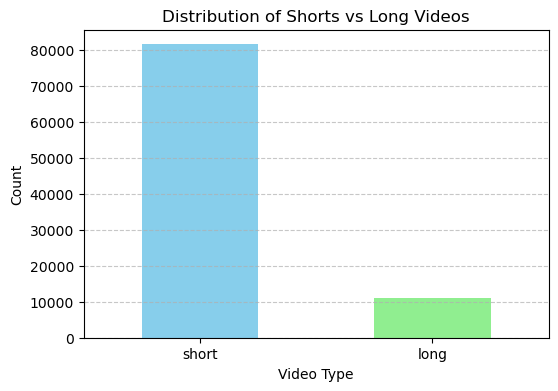

In [26]:
# --- 1) Plot Shorts vs Long ---
plt.figure(figsize=(6,4))
df["video_type"].value_counts().plot(kind="bar", color=["skyblue","lightgreen"])
plt.title("Distribution of Shorts vs Long Videos")
plt.xlabel("Video Type")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


#### Interpretation:

The dataset is extremely skewed toward short videos (≤60s), with over 80k entries to only ~11k long-form videos, which suggests the platform ecosystem (and audiences) are skewed to short-form content, making TikTok/Reels/YouTube Shorts a significant reach strategy.

### Language Detection

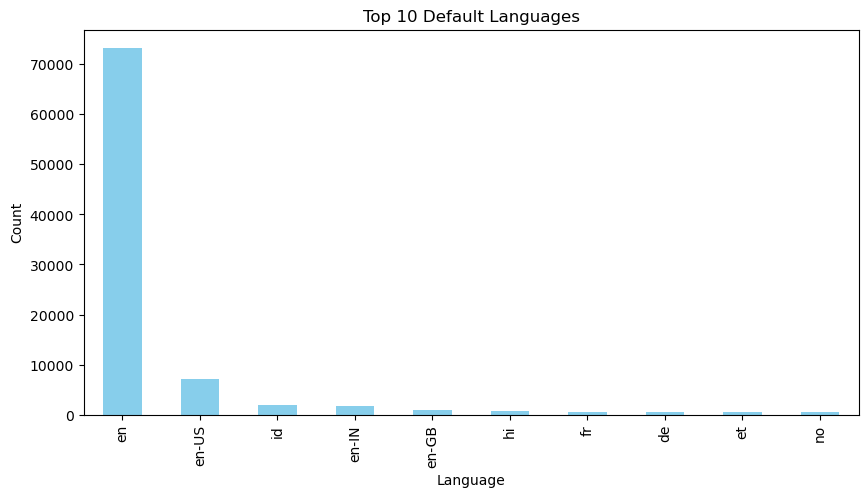

In [29]:
# ---------- Language distribution ----------
plt.figure(figsize=(10,5))
df["defaultLanguage"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Default Languages")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()

#### Interpretation:

English is overwhelmingly dominant as the default language (~73k videos) and is followed by a much smaller subset of localized English variants (en-US, en-IN, en-GB), with non-English languages (Indonesian, Hindi, German, French) appearing in very low volumes, indicating that beauty trend discussions are predominantly happening in English-speaking communities.

### Multivariate Analysis

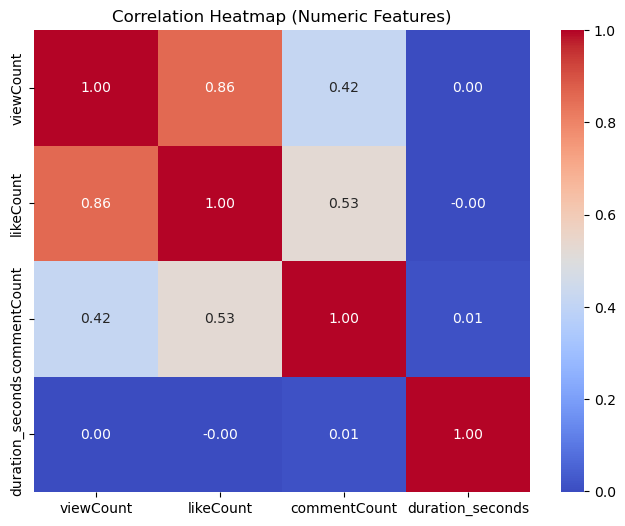

In [32]:
# ---------- Correlation heatmap ----------
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
exclude_cols = ["videoId", "channelId"]
num_cols = [c for c in num_cols if c not in exclude_cols]

plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

#### Interpretation:

From the correlation heatmap, we can see that all engagement metrics are highly correlated: **viewCount and likeCount** have a high positive correlation **(0.86)**, **likeCount and commentCount** have a **moderate positive correlation (0.53)**, and there is little or no correlation with **duration_seconds (near-zero correlation)**, which confirms our decision to treat shorts and long-form as separate categories in the trend analysis and not assume longer videos perform differently by default (i.e., for L’Oréal, it means that both formats can host impactful trends, and cultural resonance [tokens/families] is more important than video duration alone).

#### Key Takeways:

If L'Oréal decides to expand into digital video marketing, our analysis would indicate that video duration is not a major concern since there appears to be little correlation between length and engagement,

- Short-form videos (≤60s) are cost-effective for high-frequency, trend-driven content.
- Long-form videos (>60s) can be reserved for storytelling or deeper brand engagement.

This suggests that budget optimization, not duration, should guide content planning.

### Scatterplot of Views and Likes

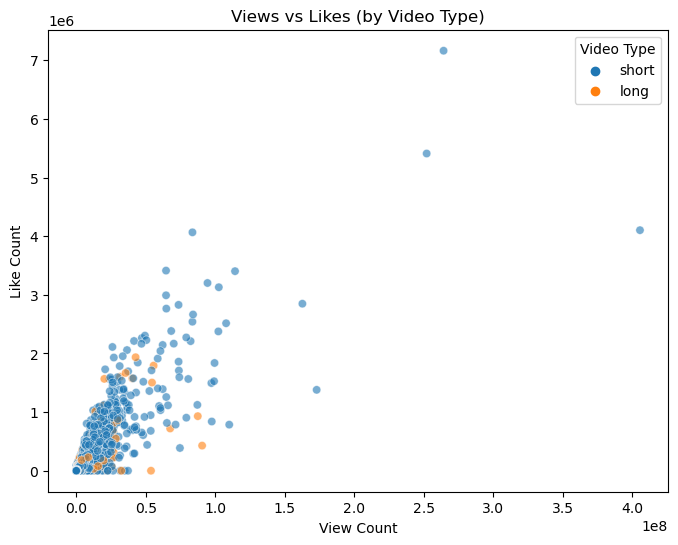

In [36]:
# ---------- Views vs Likes ----------
plt.figure(figsize=(8,6))
sns.scatterplot(x="viewCount", y="likeCount", hue="video_type", alpha=0.6, data=df)
plt.title("Views vs Likes (by Video Type)")
plt.xlabel("View Count")
plt.ylabel("Like Count")
plt.legend(title="Video Type")
plt.show()

#### Interpretation:

There is a **high positive correlation** between **views and likes**, meaning that videos that receive more views tend to get more likes. The engagement cluster is primarily shorts, most of the high-view, high-like points are shorts, and there are only a few long-form videos, which occasionally have high engagement (e.g., one long video with ~8M views and ~450k likes).

#### Takeaways:
Explain: The **primary driver of engagement at scale is shorts**, but long videos may occasionally go viral.

### Translate all language into English

In [39]:
# Translate non-English video metadata to English (title & description)
from tqdm import tqdm

tqdm.pandas()  # enable .progress_apply()

# Step 1: Detect language once (cache it)
df["lang"] = df["title"].astype(str).progress_apply(detect_lang)
df["lang"] = df["description"].astype(str).progress_apply(detect_lang)

# Step 2: Normalize English variants
df["lang"] = df["lang"].str.lower().replace({"en-us":"en","en-in":"en","en-gb":"en"})

# Step 3: Translate only non-English rows
mask = (df["lang"] != "en") & (df["lang"] != "und")

print(f"Total rows: {len(df)}")
print(f"Rows needing translation: {mask.sum()}")

# Only translate these
#df.loc[mask, "title"] = df.loc[mask, "title"].astype(str).progress_apply(maybe_translate)
#df.loc[mask, "description"] = df.loc[mask, "description"].astype(str).progress_apply(maybe_translate)


100%|██████████| 92759/92759 [03:15<00:00, 474.74it/s]


Total rows: 92759
Rows needing translation: 2899


## 2) Hashtag/Keyword Extraction (Tokens)

In [41]:
# --- Patterns & stopwords ---
hashtag_pattern = re.compile(r"#(\w+)")
word_pattern = re.compile(r"[A-Za-z][A-Za-z0-9_]+")

stopwords = set("""
a an and the or for of to in on with by from at is are was were be been being
this that those these it its as if but so not no you your our their my me we us
i they he she them him her than then there here when where how what which who like
lol lmao rofl omg tbh idk bruh bro sis slay slaying period fr frfr cap nocap no-cap have fok fyp
haha hehe huhu yass yasss ayy ayo aiyo oop oops missed sunday known regular won jesus quot
ridiculous died naa fly senior hours high means choose brought turn given sonakshi sinha
humid dreads grrr sonakshisinha viralvideo shorts viral youtubeshorts summer trending video love
""".split())

# --- Helper: parse tags safely ---
def parse_tags(val: str):
    val = val.strip()
    tags = []
    if not val:
        return tags
    # Try Python list literal
    if val.startswith("[") and val.endswith("]"):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                tags = [str(t).strip() for t in parsed if str(t).strip()]
        except Exception:
            pass
    # Fallback split
    if not tags:
        sep = "|" if "|" in val else ","
        rough = [t.strip() for t in val.split(sep)]
        tags = [t.strip(" '\"[]") for t in rough if t.strip(" '\"[]")]
    return [t for t in tags if t]

# --- Token extraction with comments & global stopword filter ---
def extract_tokens_with_comments(title, description, tags_list, comments_text):
    toks = []

    # Hashtags
    hashtags = hashtag_pattern.findall(f"{title} {description} {comments_text}")
    toks.extend([h.lower() for h in hashtags])

    # Explicit tags
    toks.extend([t.lower() for t in tags_list if len(t) >= 2])

    # Words from title + comments
    words = [w.lower() for w in word_pattern.findall(title + " " + comments_text)]
    words = [w for w in words if len(w) >= 3]
    toks.extend(words)

    # Global stopword filter (applies to hashtags, tags, words)
    toks = [t for t in toks if t not in stopwords]

    # Deduplicate per video
    return list(set(toks))

# --- Apply tags parser ---
df["tags_list"] = df["tags"].apply(parse_tags)

# --- Merge comments if available ---
import glob
comment_paths = sorted(glob.glob("comments*.csv")) if USE_COMMENTS else []
frames = []
needed = {"commentId","videoId","textOriginal","likeCount"}

for p in comment_paths:
    try:
        dfc = pd.read_csv(p)
        for col in needed:
            if col not in dfc.columns:
                dfc[col] = np.nan
        frames.append(dfc[list(needed)])
        print(f"Loaded {p}: {len(dfc):,} rows")
    except Exception as e:
        print(f"Skip {p}: {e}")

if frames:
    com_all = pd.concat(frames, ignore_index=True)

    def clean_comment_text(s: str) -> str:
        s = str(s)
        s = s.encode("utf-8","ignore").decode("utf-8","ignore")
        return s.replace("\r"," ").replace("\n"," ").strip()

    com_all["videoId"] = com_all["videoId"].astype(str)
    com_all["textOriginal"] = com_all["textOriginal"].fillna("").astype(str).apply(clean_comment_text)
    com_all["likeCount"] = pd.to_numeric(com_all["likeCount"], errors="coerce").fillna(0)

    if "commentId" in com_all.columns:
        com_all = com_all.drop_duplicates(subset=["commentId"])
    com_all = com_all.drop_duplicates()

    MAX_CHARS = 20000
    com_agg = (com_all.groupby("videoId")["textOriginal"]
               .apply(lambda s: " ".join(s.tolist())[:MAX_CHARS])
               .reset_index()
               .rename(columns={"textOriginal":"comments_text"}))
else:
    print("No comments*.csv found — continuing without comments.")
    com_agg = pd.DataFrame(columns=["videoId","comments_text"])

# --- Merge comments into df ---
df["videoId"] = df["videoId"].astype(str)
df = df.merge(com_agg, on="videoId", how="left")
df["comments_text"] = df["comments_text"].fillna("")

# --- Apply token extraction ---
df["tokens"] = df.apply(
    lambda r: extract_tokens_with_comments(r["title"], r["description"], r["tags_list"], r["comments_text"]),
    axis=1
)

df = df[df["tokens"].map(len) > 0].copy()
df["week"] = df["publishedAt_local"].dt.to_period("W").apply(lambda p: p.start_time)

Loaded comments1.csv: 1,000,000 rows
Loaded comments2.csv: 999,999 rows
Loaded comments3.csv: 999,999 rows
Loaded comments4.csv: 999,999 rows
Loaded comments5.csv: 725,015 rows


C:\Users\lunwe\AppData\Local\Temp\ipykernel_34556\1591748779.py:115: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["publishedAt_local"].dt.to_period("W").apply(lambda p: p.start_time)


### Post-EDA (Joining Comment Table)

In [43]:
print("Dataset shape:", df.shape)
print("\n Columns:", df.columns.tolist())

Dataset shape: (92651, 21)

 Columns: ['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description', 'tags', 'defaultLanguage', 'defaultAudioLanguage', 'viewCount', 'likeCount', 'commentCount', 'topicCategories', 'publishedAt_local', 'duration_seconds', 'video_type', 'lang', 'tags_list', 'comments_text', 'tokens', 'week']


In [44]:
print("\n Missing values:")
display(df.isna().sum())


 Missing values:


kind                    0
videoId                 0
publishedAt             0
channelId               0
title                   0
description             0
tags                    0
defaultLanguage         0
defaultAudioLanguage    0
viewCount               0
likeCount               0
commentCount            0
topicCategories         0
publishedAt_local       0
duration_seconds        0
video_type              0
lang                    0
tags_list               0
comments_text           0
tokens                  0
week                    0
dtype: int64

## 3) Trend Growth

In [46]:
# --- Explode tokens ---
exploded = df[[
    "videoId","publishedAt_local","week","tokens","topicCategories",
    "viewCount","likeCount","commentCount"
]].explode("tokens").rename(columns={"tokens":"token"})

# Normalize token text
exploded["token"] = exploded["token"].str.replace("^#", "", regex=True)
exploded = exploded[exploded["token"].str.len() >= 3]

# Optional unification map
unify_map = {}
def unify_token(t):
    for pattern, repl in unify_map.items():
        if re.match(pattern, t):
            return repl
    return re.sub(r"\s+", "_", t)

exploded["token"] = exploded["token"].apply(unify_token)

def get_top_trends(exploded, window_days=30, min_count=5, top_n=10):
    """
    Compute top trending tokens within a sliding time window.

    Parameters:
        exploded   : DataFrame with ['token','publishedAt_local','week'] at minimum
        window_days: int, size of the recent window in days (default=30)
        min_count  : int, minimum count in recent window to consider (default=5)
        top_n      : int, number of top trends to return (default=10)

    Returns:
        DataFrame of top_n trending tokens with growth metrics
    """

    # --- Weekly counts across all data ---
    weekly_counts = (
        exploded.groupby(["week","token"])
        .size()
        .reset_index(name="count")
        .sort_values(["token","week"])
    )

    # --- Define windows ---
    max_dt = exploded["publishedAt_local"].max()
    end_date = pd.Timestamp(max_dt.date()) + pd.Timedelta(days=1)
    start_recent = end_date - pd.Timedelta(days=window_days)
    start_prev   = start_recent - pd.Timedelta(days=window_days)

    def window_sum(df_counts, start, end):
        mask = (df_counts["week"] >= start) & (df_counts["week"] < end)
        return (
            df_counts[mask].groupby("token")["count"].sum()
            .rename("count").reset_index()
        )

    # --- Aggregate counts for both windows ---
    recent = window_sum(weekly_counts, start_recent, end_date)
    prev   = window_sum(weekly_counts, start_prev, start_recent)

    # --- Merge & growth metrics ---
    trend = recent.merge(prev, on="token", how="left", suffixes=("_recent","_prev"))
    trend = trend.fillna({"count_prev":0})
    trend["growth_abs"] = trend["count_recent"] - trend["count_prev"]

    # Cap new trends as 3x growth instead of ∞
    trend["growth_rate"] = trend.apply(
        lambda r: (r["count_recent"]/r["count_prev"])
                  if r["count_prev"] > 0
                  else (3 if r["count_recent"] > 0 else 0),
        axis=1
    )

    # --- Filter & ranking ---
    trend = trend[trend["count_recent"] >= min_count].copy()
    trend["rank_score"] = trend["growth_abs"] * np.minimum(trend["growth_rate"], 5)

    top_trends = (
        trend.sort_values(["rank_score","count_recent"], ascending=[False, False])
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_trends


In [47]:
# Top 10 trends in last 30 days
top30 = get_top_trends(exploded, window_days=30, top_n=10)

# Top 10 trends in last 90 days
top90 = get_top_trends(exploded, window_days=90, top_n=10)

In [48]:
print("Monthly risers:")
display(top30)

print("Sustained 3-month trends:")
display(top90)

📈 Monthly risers:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score
0,cosmetic_crafts,21,0.0,21.0,3.000000,63.000000
1,cosmeticcrafts,21,0.0,21.0,3.000000,63.000000
2,hair_before_after,12,1.0,11.0,12.000000,55.000000
3,haircut_power,12,1.0,11.0,12.000000,55.000000
4,hairfall,10,1.0,9.0,10.000000,45.000000
5,fragrances,27,11.0,16.0,2.454545,39.272727
6,ponytail,18,6.0,12.0,3.000000,36.000000
7,ladies_haircut,15,5.0,10.0,3.000000,30.000000
8,matteinklipstick,10,0.0,10.0,3.000000,30.000000
9,before_and_after_hair,7,1.0,6.0,7.000000,30.000000


📊 Sustained 3-month trends:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score
0,makeup,3519,1996.0,1523.0,1.763026,2685.088677
1,beauty,2394,1506.0,888.0,1.589641,1411.601594
2,skincare,1339,741.0,598.0,1.807018,1080.596491
3,look,1646,1027.0,619.0,1.602726,992.087634
4,face,1195,700.0,495.0,1.707143,845.035714
5,glow,816,440.0,376.0,1.854545,697.309091
6,makeuptutorial,945,551.0,394.0,1.715064,675.735027
7,beautiful,1524,1059.0,465.0,1.439093,669.178470
8,hair,2619,2113.0,506.0,1.239470,627.171794
9,girl,973,599.0,374.0,1.624374,607.515860


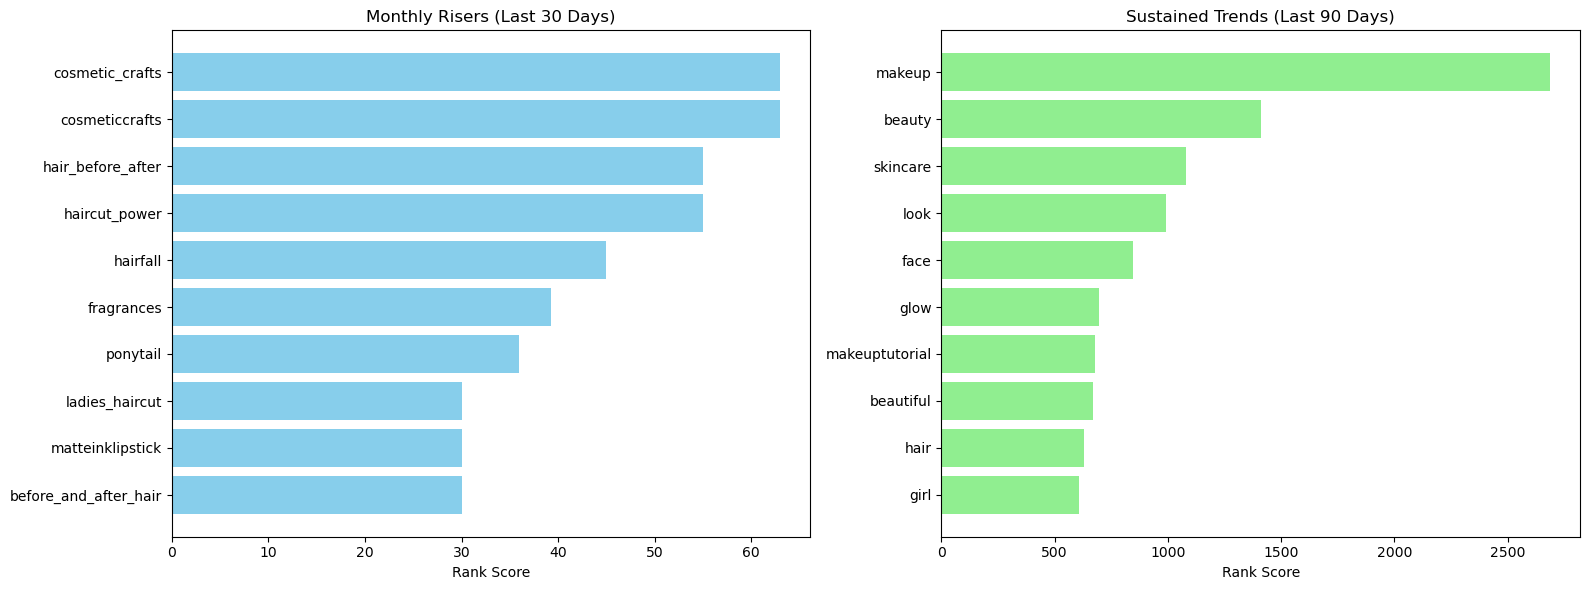

In [49]:
# Plot side-by-side bars
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=False)

# --- Monthly risers ---
axes[0].barh(top30["token"], top30["rank_score"], color="skyblue")
axes[0].invert_yaxis()
axes[0].set_title("Monthly Risers (Last 30 Days)")
axes[0].set_xlabel("Rank Score")

# --- Sustained trends ---
axes[1].barh(top90["token"], top90["rank_score"], color="lightgreen")
axes[1].invert_yaxis()
axes[1].set_title("Sustained Trends (Last 90 Days)")
axes[1].set_xlabel("Rank Score")

plt.tight_layout()
plt.show()

#### Interpretation:

**1. Monthly Risers (30 Days) – short-term spikes**
- These chart details are fast-moving opportunities — great for campaign hooks, quick content, or product tie-ins, which shows "What's hot now".
- **cosmetic_crafts**: explosive entry, likely a new DIY / handmade beauty niche. Because they appear suddenly, they’re **hype-driven but not yet proven stable**.
- **hair-like** keyword are cover up the majority of the charts, showing big interest in transformational hair content (before/after shots, power cuts, hair loss recovery). This shows a surge in visual storytelling trends.

**2. Sustained Trends (90 Days) – long-term anchors**
- These chart details are stable foundations — safe bets for brand positioning, evergreen tutorials, and product lines, which shows "What always works."
- **makeup**: dominates massively → still the core anchor of beauty content, safe for consistent engagement.
- **beauty, skincare, look, face**: broad and durable themes, forming the pillars of the beauty ecosystem.

### Decay Analysis — Trends in Montly and Sustained

In [52]:
def get_trends_with_decay(exploded, window_days=30, min_count=5, top_n=5):
    """
    Compute trending tokens (rising + declining) within a sliding time window.
    """

    # --- Weekly counts ---
    weekly_counts = (
        exploded.groupby(["week","token"])
        .size()
        .reset_index(name="count")
        .sort_values(["token","week"])
    )

    # --- Define windows ---
    max_dt = exploded["publishedAt_local"].max()
    end_date = pd.Timestamp(max_dt.date()) + pd.Timedelta(days=1)
    start_recent = end_date - pd.Timedelta(days=window_days)
    start_prev   = start_recent - pd.Timedelta(days=window_days)

    def window_sum(df_counts, start, end):
        mask = (df_counts["week"] >= start) & (df_counts["week"] < end)
        return (
            df_counts[mask].groupby("token")["count"].sum()
            .rename("count").reset_index()
        )

    # --- Aggregate counts ---
    recent = window_sum(weekly_counts, start_recent, end_date)
    prev   = window_sum(weekly_counts, start_prev, start_recent)

    # --- Merge & compute growth ---
    trend = recent.merge(prev, on="token", how="left", suffixes=("_recent","_prev"))
    trend = trend.fillna({"count_prev":0})
    trend["growth_abs"] = trend["count_recent"] - trend["count_prev"]
    trend["growth_rate"] = trend.apply(
        lambda r: (r["count_recent"]/r["count_prev"])
                  if r["count_prev"] > 0
                  else (np.inf if r["count_recent"] > 0 else 0),
        axis=1
    )

    # --- Filter ---
    trend = trend[trend["count_recent"] >= min_count].copy()

    # --- Rank score (same as before) ---
    trend["rank_score"] = trend["growth_abs"] * np.where(
        np.isinf(trend["growth_rate"]),
        3,
        np.minimum(trend["growth_rate"], 5)
    )

    # --- Classify trends ---
    trend["status"] = trend["growth_abs"].apply(
        lambda g: "📈 Rising" if g > 0 else ("🔻 Declining" if g < 0 else "⏸ Stable")
    )

    # --- Split results ---
    top_risers   = (trend[trend["growth_abs"] > 0]
                    .sort_values(["rank_score","count_recent"], ascending=[False, False])
                    .head(top_n)
                    .reset_index(drop=True))

    top_declines = (trend[trend["growth_abs"] < 0]
                    .sort_values(["growth_abs","count_recent"], ascending=[True, False])
                    .head(top_n)
                    .reset_index(drop=True))

    return top_risers, top_declines, trend


In [53]:
# Monthly risers (30 days)
monthly_risers, monthly_declines, monthly_all = get_trends_with_decay(exploded, window_days=30)

# Sustained trends (90 days)
sustained_risers, sustained_declines, sustained_all = get_trends_with_decay(exploded, window_days=90)

In [54]:
print("Monthly Risers:")
display(monthly_risers)

print("Monthly Declines:")
display(monthly_declines)

📈 Monthly Risers:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score,status
0,cosmetic_crafts,21,0.0,21.0,inf,63.0,📈 Rising
1,cosmeticcrafts,21,0.0,21.0,inf,63.0,📈 Rising
2,hair_before_after,12,1.0,11.0,12.0,55.0,📈 Rising
3,haircut_power,12,1.0,11.0,12.0,55.0,📈 Rising
4,hairfall,10,1.0,9.0,10.0,45.0,📈 Rising


🔻 Monthly Declines:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score,status
0,makeup,694,1548.0,-854.0,0.448320,-382.865633,🔻 Declining
1,beauty,435,1017.0,-582.0,0.427729,-248.938053,🔻 Declining
2,hair,598,993.0,-395.0,0.602216,-237.875126,🔻 Declining
3,makeuptutorial,186,451.0,-265.0,0.412417,-109.290466,🔻 Declining
4,look,415,650.0,-235.0,0.638462,-150.038462,🔻 Declining


In [55]:
print("Sustained Risers:")
display(sustained_risers)

print("Sustained Declines:")
display(sustained_declines)

🏆 Sustained Risers:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score,status
0,makeup,3519,1996.0,1523.0,1.763026,2685.088677,📈 Rising
1,beauty,2394,1506.0,888.0,1.589641,1411.601594,📈 Rising
2,skincare,1339,741.0,598.0,1.807018,1080.596491,📈 Rising
3,look,1646,1027.0,619.0,1.602726,992.087634,📈 Rising
4,face,1195,700.0,495.0,1.707143,845.035714,📈 Rising


🔻 Sustained Declines:


,token,count_recent,count_prev,growth_abs,growth_rate,rank_score,status
0,valentine,6,47.0,-41.0,0.127660,-5.234043,🔻 Declining
1,keratin,27,53.0,-26.0,0.509434,-13.245283,🔻 Declining
2,eye_makeup,15,35.0,-20.0,0.428571,-8.571429,🔻 Declining
3,smoothing,89,108.0,-19.0,0.824074,-15.657407,🔻 Declining
4,mousse,47,66.0,-19.0,0.712121,-13.530303,🔻 Declining


## DL Mode — Semantic Topic Clustering (Transformer -> KMeans)

In [57]:
def get_semantic_topics(df, window_days=30, min_count=5, top_n=10, sample_size=5000):
    """
    Cluster recent video titles into semantic topics and compute trending topics.
    Ensures cluster labels use unique words globally (no repeated keywords across clusters).
    """

    # --- Ensure naive timestamp ---
    if "published_local_naive" not in df.columns:
        df["published_local_naive"] = (
            df["publishedAt_local"]
            .dt.tz_convert("Asia/Kuala_Lumpur")
            .dt.tz_localize(None)
        )

    # --- Define windows ---
    end_date     = df["published_local_naive"].max().normalize() + pd.Timedelta(days=1)
    start_recent = end_date - pd.Timedelta(days=window_days)
    start_prev   = start_recent - pd.Timedelta(days=window_days)

    # --- Filter recent titles ---
    recent_mask   = (df["published_local_naive"] >= start_recent) & (df["published_local_naive"] < end_date)
    titles_recent = df.loc[recent_mask, "title"].dropna().astype(str)

    if len(titles_recent) < 50:
        print(f"Not enough titles in last {window_days}d (<50). Skipping.")
        return None, None

    df_recent = None

    try:
        # --- SentenceTransformer + KMeans ---
        print(f"Semantic clustering {window_days}d: Using SentenceTransformer embeddings + KMeans")
        from sentence_transformers import SentenceTransformer
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score
        import collections, re

        # Sample for speed
        titles_sample = titles_recent.sample(min(sample_size, len(titles_recent)), random_state=42)

        # Embeddings
        model = SentenceTransformer("all-MiniLM-L6-v2")
        X = model.encode(titles_sample.tolist(), normalize_embeddings=True)

        # Find best k
        best_k, best_score, best_km = None, -1, None
        for k in [6, 8, 10, 12]:
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            labels_try = km.fit_predict(X)
            try:
                score = silhouette_score(X, labels_try)
            except Exception:
                score = -1
            if score > best_score:
                best_k, best_score, best_km = k, score, km

        # Build cluster labels
        labels = best_km.predict(X)
        cluster_titles = pd.DataFrame({"title": titles_sample.values, "cluster": labels})

        stop = set("""a an the and or for of to in on with by from this that those these it its as if but so not no you your our their my me we us 
        i they he she them him her than then there here when where how what which who is are was were be been being
        lol lmao rofl omg tbh idk bruh bro sis slay slaying period fr frfr cap nocap no-cap have fok fyp
        haha hehe huhu yass yasss ayy ayo aiyo oop oops missed sunday known regular won jesus quot
        ridiculous died naa fly senior hours high means choose brought turn given
        humid dreads viralvideo shorts viral youtubeshorts summer trending video love shortvideo short ytshorts shortsfeed youtube trendingshorts""".split())
        def words(s): return re.findall(r"[A-Za-z][A-Za-z0-9_]+", s.lower())

        # --- Global deduplication across clusters ---
        topic_labels = {}
        used_words = set()

        for c, grp in cluster_titles.groupby("cluster"):
            cnt = collections.Counter(
                w for t in grp["title"] for w in words(t) if len(w) >= 3 and w not in stop
            )
            # keep only fresh words not yet used
            candidates = [(w, freq) for w, freq in cnt.most_common(15) if w not in used_words]

            # pick top 3 unique words
            common = [w for w, _ in candidates[:3]]
            if not common:  # fallback if all were duplicates
                common = [w for w, _ in cnt.most_common(3)]

            topic_labels[c] = ", ".join(common) if common else f"topic_{c}"

            # mark them as reserved globally
            used_words.update(common)

        # Assign clusters to all recent titles
        df_recent = df.loc[recent_mask, ["videoId","title","published_local_naive"]].dropna().copy()
        Z = model.encode(df_recent["title"].tolist(), normalize_embeddings=True)
        cluster_ids = best_km.predict(Z)
        df_recent["topic_label"] = [topic_labels.get(c, f"topic_{c}") for c in cluster_ids]

    except Exception as e:
        # --- Fallback TF-IDF + KMeans ---
        print(f"Semantic clustering {window_days}d: Fallback TF-IDF + KMeans. Error:", e)
        from sklearn.cluster import KMeans
        from sklearn.feature_extraction.text import TfidfVectorizer

        vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=3)
        X = vec.fit_transform(titles_recent)
        km = KMeans(n_clusters=10, n_init=10, random_state=42).fit(X)

        df_recent = pd.DataFrame({
            "title": titles_recent.values,
            "published_local_naive": df.loc[recent_mask, "published_local_naive"].values[:len(titles_recent)]
        })
        df_recent["topic_label"] = km.labels_.astype(str)

    # --- Topic weekly counts + growth ---
    df_recent["week"] = df_recent["published_local_naive"].dt.to_period("W").apply(lambda p: p.start_time)

    topic_weekly = (df_recent.groupby(["week", "topic_label"])
                    .size().reset_index(name="count")
                    .sort_values(["topic_label","week"]))

    def window_sum_topic(dfc, start, end):
        m = (dfc["week"] >= start) & (dfc["week"] < end)
        return (dfc[m].groupby("topic_label")["count"].sum().rename("count").reset_index())

    topic_recent = window_sum_topic(topic_weekly, start_recent, end_date)
    topic_prev   = window_sum_topic(topic_weekly, start_prev, start_recent)

    topic_trend = (topic_recent.merge(topic_prev, on="topic_label", how="left", suffixes=("_recent","_prev"))
                              .fillna({"count_prev": 0}))
    topic_trend["growth_abs"]  = topic_trend["count_recent"] - topic_trend["count_prev"]
    topic_trend["growth_rate"] = topic_trend.apply(
        lambda r: (r["count_recent"]/r["count_prev"]) if r["count_prev"]>0 else (np.inf if r["count_recent"]>0 else 0),
        axis=1
    )
    topic_trend = topic_trend[topic_trend["count_recent"] >= min_count].copy()
    topic_trend["rank_score"] = topic_trend["growth_abs"] * np.where(
        np.isinf(topic_trend["growth_rate"]), 3, np.minimum(topic_trend["growth_rate"], 5)
    )

    # --- Top topics ---
    top_topics = topic_trend.sort_values(["rank_score","count_recent"], ascending=[False, False]).head(top_n)

    return top_topics, topic_trend


In [58]:
# Monthly semantic topics
monthly_topics, monthly_topics_all = get_semantic_topics(df, window_days=30)

# Sustained 3-month semantic topics
sustained_topics, sustained_topics_all = get_semantic_topics(df, window_days=90)

print("Monthly Semantic Topics:")
display(monthly_topics)

print("Sustained Semantic Topics:")
display(sustained_topics)

Semantic clustering 30d: Using SentenceTransformer embeddings + KMeans


C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Semantic clustering 90d: Using SentenceTransformer embeddings + KMeans


C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Monthly Semantic Topics:


,topic_label,count_recent,count_prev,growth_abs,growth_rate,rank_score
5,"transformation, hairtransformation, haircut",496,147,349,3.374150,1177.578231
0,"beauty, finishing, grwm",366,92,274,3.978261,1090.043478
1,"face, skin, yoga",306,68,238,4.500000,1071.000000
4,"makeup, makeuptutorial, look",519,175,344,2.965714,1020.205714
3,"hair, hairstyle, contour",340,102,238,3.333333,793.333333
2,"glow, glowup, skincare",215,71,144,3.028169,436.056338


Sustained Semantic Topics:


,topic_label,count_recent,count_prev,growth_abs,growth_rate,rank_score
5,"makeuptutorial, lipstick, makeupartist",2341,0.0,2341.0,inf,7023.0
4,"hair, hairstyle, transformation",2316,0.0,2316.0,inf,6948.0
2,"face, contour, viralshorts",1396,0.0,1396.0,inf,4188.0
1,"beauty, amp, look",1301,0.0,1301.0,inf,3903.0
6,"skincare, makeup, bodylotion",1032,0.0,1032.0,inf,3096.0
7,"yoga, anti, aging",1017,0.0,1017.0,inf,3051.0
3,"glow, glowup, skin",834,0.0,834.0,inf,2502.0
0,"balayage, song, body",736,0.0,736.0,inf,2208.0


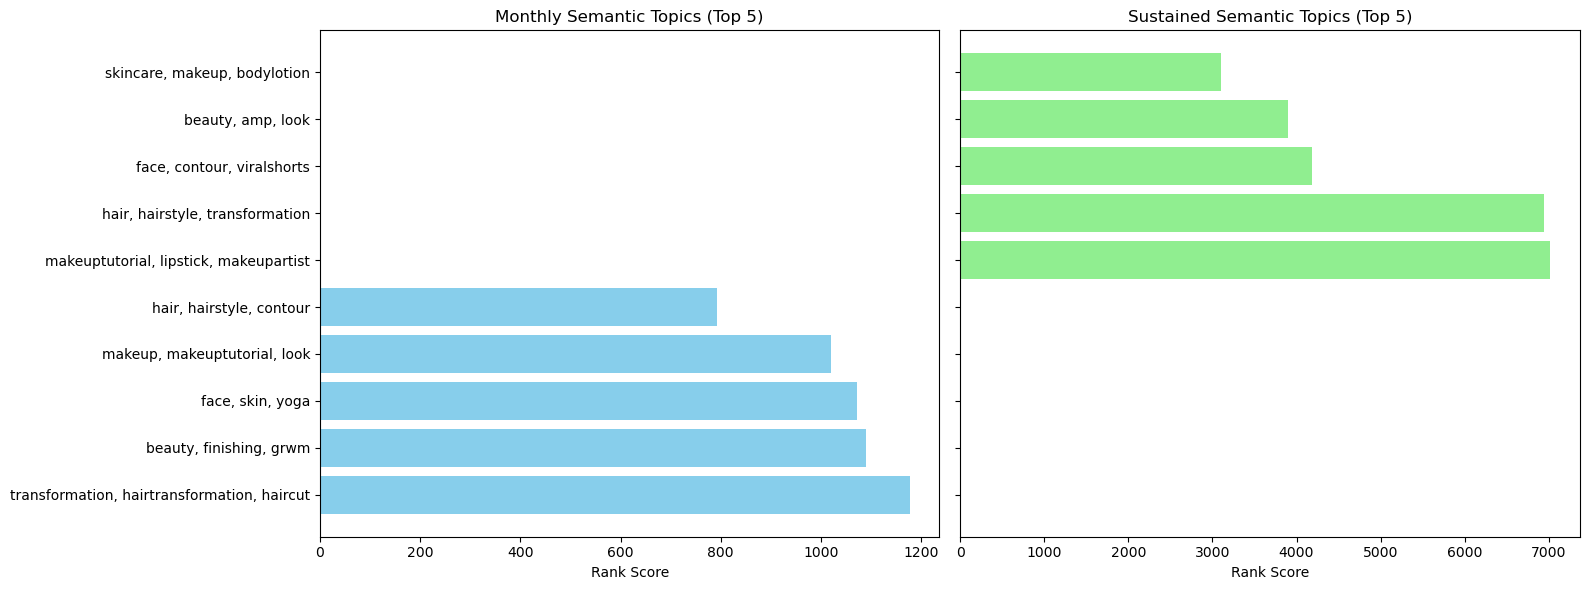

In [59]:
import matplotlib.pyplot as plt

def plot_semantic_topics(monthly_df, sustained_df, top_n=5):
    """
    Compare Monthly vs Sustained semantic topics in two bar charts.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

    # --- Monthly ---
    if monthly_df is not None and not monthly_df.empty:
        mdf = monthly_df.head(top_n)
        axes[0].barh(mdf["topic_label"], mdf["rank_score"], color="skyblue")
        axes[0].set_title(f"Monthly Semantic Topics (Top {top_n})")
        axes[0].invert_yaxis()
        axes[0].set_xlabel("Rank Score")

    # --- Sustained ---
    if sustained_df is not None and not sustained_df.empty:
        sdf = sustained_df.head(top_n)
        axes[1].barh(sdf["topic_label"], sdf["rank_score"], color="lightgreen")
        axes[1].set_title(f"Sustained Semantic Topics (Top {top_n})")
        axes[1].invert_yaxis()
        axes[1].set_xlabel("Rank Score")

    plt.tight_layout()
    plt.show()


# Example usage
plot_semantic_topics(monthly_topics, sustained_topics, top_n=5)

#### Interpretation:

##### Left Chart – Monthly Semantic Topics (Top 5)
- short-term spikes are dominated by **transformational hair content** and **daily beauty routines**.

##### Right Chart – Sustained Semantic Topics (Top 5)
- sustained clusters are **makeup tutorials** and **skincare routines**.

# TrendSpotter Insights — Comparative View

## A. Monthly vs Sustained Trends

### Monthly Risers (Last 30 Days)
- Sudden spikes in **hair-related transformations** (hair_before_after, haircut_power, hairfall, ponytail).
- Emerging beauty micro-trends like **cosmetic crafts** and **matte ink lipstick**.
- These signals capture **short-term volatility** — trends that might fade quickly.

### Sustained Trends (Last 90 Days)
- **Makeup** and **beauty** remain the **core long-term anchors**, with consistently high engagement.
- **Skincare** and **face/contouring** show stable growth and form a strong foundation.
- **Hair** also sustains momentum, but less dominant compared to makeup and skincare.

---

## B. Monthly vs Sustained Semantic Topics

### Monthly Semantic Topics
- **Transformation, hairtransformation, haircut** → strong buzz, linked to before/after content.
- **Beauty finishing & GRWM** (get ready with me) → viral routines gaining traction.
- **Skincare** → holistic beauty/wellness integration.

### Sustained Semantic Topics
- **Makeup tutorials (lipstick, makeup artist)** → long-lasting attention driver.
- **Hair transformation** remains a backbone.
- **Skincare & beauty crossover** is consistently present.
- **Contour & look-based topics** → visual-driven, stable appeal.

---

## Key Takeaways
- **Monthly (Volatility / Spikes):** Hair transformations and experimental routines are driving short-term attention.
- **Sustained (Stability / Foundations):** Makeup tutorials and skincare clusters anchor long-term community engagement.

---

## Implications for L’Oréal
- **Short-term plays:**  
  - Activate campaigns around before-after transformations, especially in **haircare content**.  
  - Leverage viral-ready formats (e.g., Shorts, TikTok) to capture spikes.

- **Long-term branding:**  
  - Continue consistent investment in **makeup tutorials** and **skincare routines**.  
  - Position L’Oréal as both **trend-responsive** and **trustworthy in routine essentials**.

---

## Next Step — Hybrid Deep Dive
To move beyond general clusters, the **hybrid analysis** (token + topic overlap) will:
- Pinpoint **specific micro-trends** (e.g., “haircut_power” vs generic “hair”).
- Balance **volatility vs stability** with a combined normalized score.
- Provide **actionable detail** for L’Oréal’s campaign targeting.

# Hybrid Model

In [63]:
from rapidfuzz import fuzz
import numpy as np
import pandas as pd

# --- 1) helpers: normalize any score column to 0–1 ---------------------------
def add_norm_01(df, score_col="rank_score", out_col="norm", method="percentile", floor_zero=True):
    """
    Return a copy of df with a 0–1 normalized column:
      - method='percentile' (rank pct; robust when there are outliers)  ← recommended
      - method='minmax'     ((x - min) / (max - min))
    floor_zero=True clips negatives to 0 before normalization (useful if you mix rises & declines).
    """
    if df is None or df.empty:
        return df.assign(**{out_col: 0.0})

    x = df.copy()
    s = x[score_col].astype(float)
    if floor_zero:
        s = s.clip(lower=0)

    if method == "percentile":
        # largest value → 1.0, smallest → ~1/n
        x[out_col] = s.rank(pct=True, ascending=True)
    elif method == "minmax":
        lo, hi = float(s.min()), float(s.max())
        x[out_col] = 0.0 if hi == lo else (s - lo) / (hi - lo)
    else:
        raise ValueError("method must be 'percentile' or 'minmax'")

    return x

# --- 2) fuzzy match + normalized hybrid score --------------------------------
def is_fuzzy_match(token, topic_label, threshold=70):
    token = str(token).lower().strip()
    words = [w.strip() for w in str(topic_label).lower().split(",")]
    return any(fuzz.partial_ratio(token, w) >= threshold for w in words)

def get_hybrid_trends_normalized(
    token_trend, topic_trend, top_n=10, threshold=70,
    w_token=0.5, w_topic=0.5, norm_method="percentile", floor_zero=True
):
    """
    Build a fair hybrid by first normalizing token/topic scores to 0–1, then
    combining with weights: hybrid = w_token*token_norm + w_topic*topic_norm
    """
    if token_trend is None or topic_trend is None or token_trend.empty or topic_trend.empty:
        return pd.DataFrame()

    tt = add_norm_01(token_trend, score_col="rank_score", out_col="token_norm",
                     method=norm_method, floor_zero=floor_zero)
    tp = add_norm_01(topic_trend, score_col="rank_score", out_col="topic_norm",
                     method=norm_method, floor_zero=floor_zero)

    # quick lookups
    token_norm_map = dict(zip(tt["token"], tt["token_norm"]))
    token_score_map = dict(zip(tt["token"], tt["rank_score"]))
    topic_norm_map = dict(zip(tp["topic_label"], tp["topic_norm"]))
    topic_score_map = dict(zip(tp["topic_label"], tp["rank_score"]))

    rows = []
    for _, t in tt.iterrows():
        tkn = t["token"]
        for _, m in tp.iterrows():
            if is_fuzzy_match(tkn, m["topic_label"], threshold=threshold):
                tn = float(token_norm_map.get(tkn, 0.0))
                tpv = float(topic_norm_map.get(m["topic_label"], 0.0))
                rows.append({
                    "token": tkn,
                    "topic_label": m["topic_label"],
                    "token_score_raw": float(token_score_map.get(tkn, 0.0)),
                    "topic_score_raw": float(topic_score_map.get(m["topic_label"], 0.0)),
                    "token_norm": tn,              # 0–1
                    "topic_norm": tpv,             # 0–1
                    "hybrid_score": w_token*tn + w_topic*tpv
                })

    out = pd.DataFrame(rows)
    if out.empty:
        print("⚠️ No fuzzy overlaps found between tokens and topics.")
        return out
    return out.sort_values("hybrid_score", ascending=False).head(top_n).reset_index(drop=True)


In [133]:
# Monthly: give more weight to recency (token) if you want
hybrid_monthly_fair = get_hybrid_trends_normalized(
    top30, monthly_topics, top_n=10,
    w_token=0.6, w_topic=0.4,           # tweak as you like
    norm_method="percentile",           # robust, scale-free
    floor_zero=True                     # clip negatives to 0 before ranking
)

# Sustained: weight topics a bit more if you prefer the long-term clusters
hybrid_sustained_fair = get_hybrid_trends_normalized(
    top90, sustained_topics, top_n=10,
    w_token=0.4, w_topic=0.6,
    norm_method="percentile",
    floor_zero=True
)

print("Hybrid Monthly (normalized 0–1):")
display(hybrid_monthly_fair)

print("Hybrid Sustained (normalized 0–1):")
display(hybrid_sustained_fair)

📈 Hybrid Monthly (normalized 0–1):


,token,topic_label,token_score_raw,topic_score_raw,token_norm,topic_norm,hybrid_score
0,hair_before_after,"transformation, hairtransformation, haircut",55.000000,1177.578231,0.75,1.000000,0.850000
1,haircut_power,"transformation, hairtransformation, haircut",55.000000,1177.578231,0.75,1.000000,0.850000
2,hairfall,"transformation, hairtransformation, haircut",45.000000,1177.578231,0.60,1.000000,0.760000
3,hair_before_after,"hair, hairstyle, contour",55.000000,793.333333,0.75,0.333333,0.583333
4,haircut_power,"hair, hairstyle, contour",55.000000,793.333333,0.75,0.333333,0.583333
5,fragrances,"face, skin, yoga",39.272727,1071.000000,0.50,0.666667,0.566667
6,ladies_haircut,"transformation, hairtransformation, haircut",30.000000,1177.578231,0.20,1.000000,0.520000
7,before_and_after_hair,"transformation, hairtransformation, haircut",30.000000,1177.578231,0.20,1.000000,0.520000
8,hairfall,"hair, hairstyle, contour",45.000000,793.333333,0.60,0.333333,0.493333
9,ladies_haircut,"hair, hairstyle, contour",30.000000,793.333333,0.20,0.333333,0.253333


🏆 Hybrid Sustained (normalized 0–1):


,token,topic_label,token_score_raw,topic_score_raw,token_norm,topic_norm,hybrid_score
0,makeup,"makeuptutorial, lipstick, makeupartist",2685.088677,7023.0,1.0,1.000,1.000
1,makeuptutorial,"makeuptutorial, lipstick, makeupartist",675.735027,7023.0,0.4,1.000,0.760
2,beauty,"beauty, amp, look",1411.601594,3903.0,0.9,0.625,0.735
3,makeup,"skincare, makeup, bodylotion",2685.088677,3096.0,1.0,0.500,0.700
4,face,"face, contour, viralshorts",845.035714,4188.0,0.6,0.750,0.690
5,look,"beauty, amp, look",992.087634,3903.0,0.7,0.625,0.655
6,skincare,"skincare, makeup, bodylotion",1080.596491,3096.0,0.8,0.500,0.620
7,hair,"hair, hairstyle, transformation",627.171794,6948.0,0.2,0.875,0.605
8,beautiful,"beauty, amp, look",669.178470,3903.0,0.3,0.625,0.495
9,girl,"face, contour, viralshorts",607.515860,4188.0,0.1,0.750,0.490


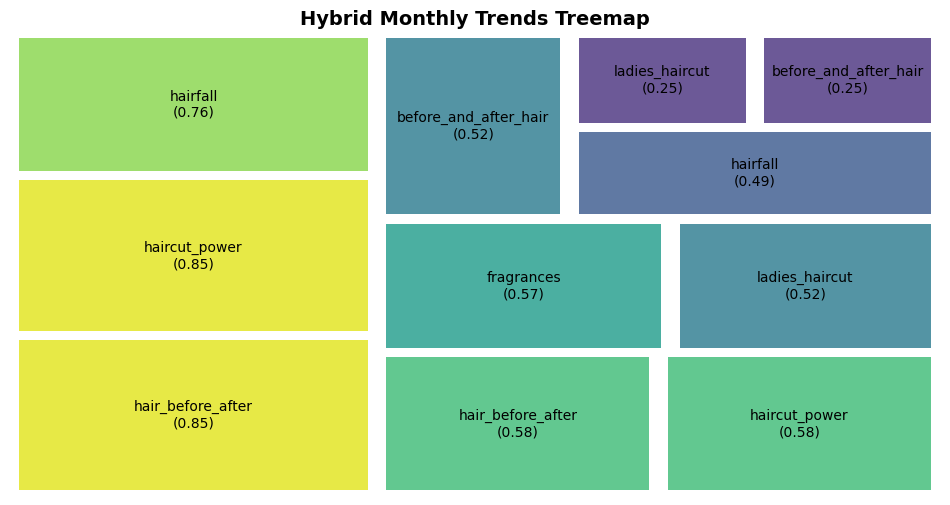

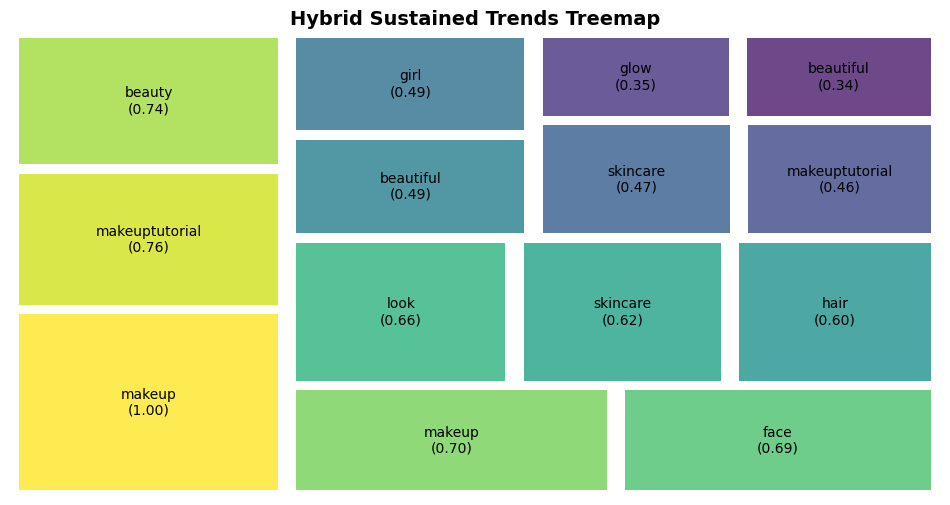

In [124]:
import matplotlib.pyplot as plt
import squarify

def plot_treemap(df, title):
    """
    Plots a treemap of tokens sized by hybrid_score.
    """
    if df is None or df.empty:
        print("No data to plot")
        return
    
    labels = [f"{row['token']}\n({row['hybrid_score']:.2f})" for _, row in df.iterrows()]
    sizes = df["hybrid_score"].values
    colors = plt.cm.viridis(df["hybrid_score"].rank(pct=True))  # color by rank
    
    plt.figure(figsize=(12,6))
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, pad=True, text_kwargs={'fontsize':10})
    plt.axis("off")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.show()

# Plot treemaps
plot_treemap(hybrid_monthly_fair, "Hybrid Monthly Trends Treemap")
plot_treemap(hybrid_sustained_fair, "Hybrid Sustained Trends Treemap")


## Interpretation:

- Hybrid Model Results focusing on the four main keywords: **Hair, Makeup, Fragrance, and Skincare**.

### 1. Hair
 - **Monthly**: The spike shows that hair-related content dominates short-term trends, and that audiences are engaging with transformational and before-after content.
- **Sustained**: Hair as a broad cluster remains present but at a lower sustained score compared to makeup, which indicates occasional viral surges but not as stable as makeup or skincare.

### 2. Makeup
 - **Makeup** is the foundation trend. It consistently drives attention, despite it doesn't dominate sudden spikes, it leads long-term with highest sustained hybrid score.

### 3. Fragrance
 - **Fragrance** is seasonal and campaign-driven, not always present in long-term baseline. L’Oréal can activate it during seasonal pushes (festive, Valentine’s, year-end sales), as it shows up **moderate hybrid score** but not appears as strongly in sustained scores.

### 4. Skincare
 - **Skincare** present in some topic overlaps (face, skin, look) but not top of monthly hybrid, and it's slightly strong consistent cluster, relfecting stable audience demand around rountine.

---

### **Next Step**

- **Family-Level Clustering**

Now that Hair, Makeup, Fragrance., and Skincare have been identified as the 4 primary hybrid families, the next logical step is to:

**Cluster all tokens into these 4 families** (using your FAMILIES dictionary). 
- Analyze weekly family-level trends to contrast momentum.Run decay/momentum metrics (slopes, pct changes) for each family.
- Visualize with family-level trendlines (last 26 weeks).
- This will illustrate: Which family is increasing most rapidly (momentum).Which family is declining.
- How L'Oréal can realign content portfolio (short-term peaks and valleys versus long-term steadiness).

## Family-level trend analysis

In [68]:
hybrid_monthly = hybrid_monthly_fair
hybrid_sustained = hybrid_sustained_fair

Family overall ranking:


,family,monthly_h,sustained_h,overall_score,avg_weekly_recent
0,hair,0.850000,0.605,0.752,405.083333
1,makeup,0.000000,1.000,0.400,1064.166667
2,fragrance,0.566667,0.000,0.340,29.750000
3,skincare,0.000000,0.620,0.248,320.083333


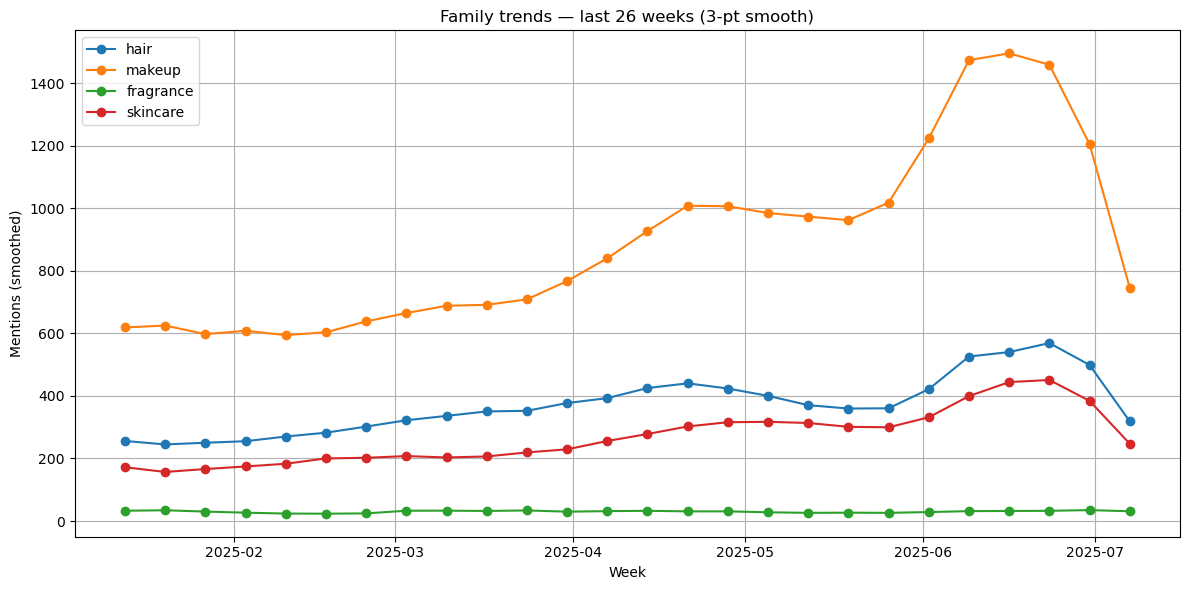

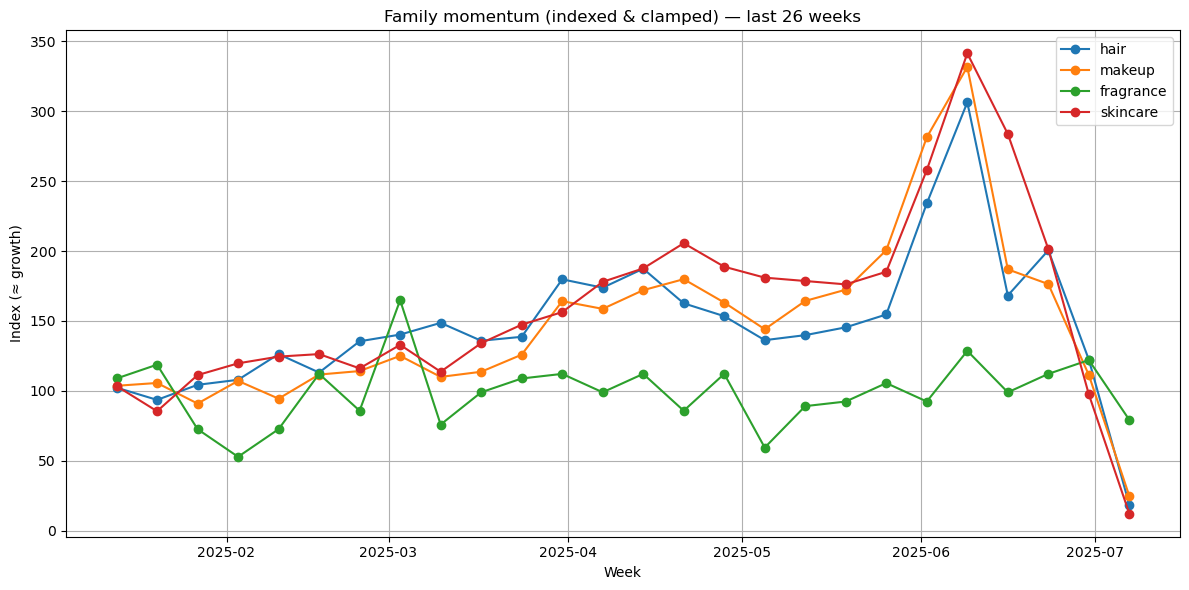

In [152]:
# =========================
# TrendSpotter — Family view
# =========================
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# --------- 0) Family dictionary (edit as you like) ----------
FAMILIES = {
    "hair": [
        "hair","hairstyle","hairstyles","haircut","haircut_power","hair_before_after",
        "before_and_after_hair","ladies_haircut","hairfall","hairtransformation","transformation"
    ],
    "makeup": [
        "makeup","makeuptutorial","makeuplook","makeuphacks","makeupartist",
        "contour","lipstick","eyeshadow","grwm","beautiful","beauty","look", "face"
    ],
    "fragrance": [
        "fragrance","fragrances","perfume","eau","cologne","scent"
    ],
    "skincare": [
        "skincare","skin","glow","glowup","face","serum","moisturizer"
    ]
}

def _to_lower(s): 
    return str(s).lower()

def _token_to_family(t):
    t = _to_lower(t)
    for fam, toks in FAMILIES.items():
        if t in toks:
            return fam
    return None

# --------- 1) Weekly counts (build if needed) ----------
try:
    weekly_counts_all
except NameError:
    # Build from your exploded table: needs columns ["week","token"]
    weekly_counts_all = (exploded.copy()
                         .assign(token=lambda d: d["token"].str.lower())
                         .groupby(["week","token"]).size()
                         .reset_index(name="count")
                         .sort_values(["token","week"]))
# Family weekly counts
wk = weekly_counts_all.copy()
wk["token"] = wk["token"].str.lower()
wk["family"] = wk["token"].map(_token_to_family)
fam_weekly = (wk.dropna(subset=["family"])
                .groupby(["week","family"])["count"]
                .sum()
                .reset_index()
                .sort_values(["family","week"]))

# --------- 2) Handle hybrid tables (accept normalized or raw) ----------
def _ensure_norm(df):
    """
    Accepts either your normalized hybrid tables (token_norm/topic_norm)
    or raw (token_score/topic_score). Returns a DF with:
    ['token','topic_label','hybrid_score']
    where hybrid_score is already 0-1 scaled.
    """
    cols = {c.lower() for c in df.columns}
    d = df.copy()
    # normalized input
    if {"token_norm","topic_norm","token","topic_label","hybrid_score"}.issubset(cols):
        return d[["token","topic_label","hybrid_score"]].copy()
    # raw input
    if {"token_score","topic_score","token","topic_label"}.issubset(cols):
        tmin,tmax = d["token_score"].min(), d["token_score"].max()
        smin,smax = d["topic_score"].min(), d["topic_score"].max()
        d["token_norm"] = 0 if tmax==tmin else (d["token_score"]-tmin)/(tmax-tmin)
        d["topic_norm"] = 0 if smax==smin else (d["topic_score"]-smin)/(smax-smin)
        d["hybrid_score"] = 0.5*d["token_norm"] + 0.5*d["topic_norm"]
        return d[["token","topic_label","hybrid_score"]].copy()
    # minimal normalized (token_norm/topic_norm but no hybrid_score)
    if {"token_norm","topic_norm","token","topic_label"}.issubset(cols):
        d["hybrid_score"] = 0.5*d["token_norm"] + 0.5*d["topic_norm"]
        return d[["token","topic_label","hybrid_score"]].copy()
    raise ValueError("Hybrid table not recognized. Provide normalized or raw hybrid tables.")

# Pick inputs you already computed
try:
    monthly_input   # normalized monthly hybrid
    sustained_input # normalized sustained hybrid
except NameError:
    try:
        monthly_input  = hybrid_monthly_norm
        sustained_input = hybrid_sustained_norm
    except NameError:
        monthly_input  = hybrid_monthly       # raw fallback
        sustained_input = hybrid_sustained

HM = _ensure_norm(monthly_input).assign(token=lambda d: d["token"].str.lower())
HS = _ensure_norm(sustained_input).assign(token=lambda d: d["token"].str.lower())

# --------- 3) Family-level ranking with a volume floor ----------
def build_family_overall_topN(HM, HS, fam_weekly,
                              topN=3, w_monthly=0.6, w_sustained=0.4,
                              lookback_weeks=12, min_avg_weekly=10,
                              agg="max"):
    # Token -> family
    HM["family"] = HM["token"].map(_token_to_family)
    HS["family"] = HS["token"].map(_token_to_family)
    HM = HM.dropna(subset=["family"])
    HS = HS.dropna(subset=["family"])

    # Aggregate hybrid score to family
    if agg == "mean":
        fam_m = HM.groupby("family")["hybrid_score"].mean().rename("monthly_h")
        fam_s = HS.groupby("family")["hybrid_score"].mean().rename("sustained_h")
    else:  # "max" (default)
        fam_m = HM.groupby("family")["hybrid_score"].max().rename("monthly_h")
        fam_s = HS.groupby("family")["hybrid_score"].max().rename("sustained_h")

    fam = pd.concat([fam_m, fam_s], axis=1).fillna(0.0)
    fam["overall_score"] = w_monthly*fam["monthly_h"] + w_sustained*fam["sustained_h"]

    # Volume floor
    end = fam_weekly["week"].max()
    start = end - pd.Timedelta(weeks=lookback_weeks)
    vol = (fam_weekly[(fam_weekly["week"]>start) & (fam_weekly["week"]<=end)]
              .groupby("family")["count"].mean()
              .rename("avg_weekly_recent"))

    out = fam.join(vol, how="left").fillna({"avg_weekly_recent":0})
    out = out[out["avg_weekly_recent"] >= min_avg_weekly]

    # --- Force include 4 key families ---
    must_have = ["hair","makeup","fragrance","skincare"]
    for fam in must_have:
        if fam not in out.index:
            out.loc[fam] = {"monthly_h":0, "sustained_h":0, "overall_score":0, "avg_weekly_recent":0}

    out = out.sort_values("overall_score", ascending=False)

    return out.reset_index(), out.head(topN).reset_index()

families_overall, top_families = build_family_overall_topN(
    HM, HS, fam_weekly,
    topN=4, w_monthly=0.6, w_sustained=0.4,
    lookback_weeks=12, min_avg_weekly=10, agg="max"
)

print("Family overall ranking:")
display(families_overall)

# --------- 5) Charts: last 26 weeks ---------
def _smooth3(s): 
    return s.rolling(4, min_periods=1).mean()

def plot_family_trends(fam_weekly, families, weeks=26, logy=False):
    df = fam_weekly.copy().sort_values("week")
    end = df["week"].max()
    start = end - pd.Timedelta(weeks=weeks)
    df = df[(df["week"]>start) & (df["week"]<=end)]
    grid = (df.set_index(["week","family"]).unstack(fill_value=0).stack().reset_index())
    grid["count_smooth"] = grid.groupby("family")["count"].transform(_smooth3)

    plt.figure(figsize=(12,6))
    for fam in families:
        sub = grid[grid["family"]==fam]
        if not sub.empty:
            plt.plot(sub["week"], sub["count_smooth"], marker="o", label=fam)
    plt.title("Family trends — last 26 weeks (3-pt smooth)")
    plt.xlabel("Week"); plt.ylabel("Mentions (smoothed)")
    if logy: plt.yscale("log")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def indexed_momentum(series):
    nz = series[series>0]
    base = nz.head(3).mean() if len(nz) else 1.0
    base = max(base, 1.0)
    idx = 100*series/base
    return idx.clip(upper=400)  # clamp ridiculous spikes

def plot_indexed_families(fam_weekly, families, weeks=26):
    df = fam_weekly.copy().sort_values("week")
    end = df["week"].max()
    start = end - pd.Timedelta(weeks=weeks)
    df = df[(df["week"]>start) & (df["week"]<=end)]
    grid = (df.set_index(["week","family"]).unstack(fill_value=0).stack().reset_index())
    grid["idx"] = grid.groupby("family")["count"].transform(indexed_momentum)

    plt.figure(figsize=(12,6))
    for fam in families:
        sub = grid[grid["family"]==fam]
        if not sub.empty:
            plt.plot(sub["week"], sub["idx"], marker="o", label=fam)
    plt.title("Family momentum (indexed & clamped) — last 26 weeks")
    plt.xlabel("Week"); plt.ylabel("Index (≈ growth)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# Plot for the top families
plot_family_trends(fam_weekly, top_families["family"].tolist(), weeks=26, logy=False)
plot_indexed_families(fam_weekly, top_families["family"].tolist(), weeks=26)

### Top Token(Keyword) in each Family

In [156]:
# Drill-down: top tokens inside a family (recent 12 weeks)

def top_tokens_in_family(weekly_counts_all, family, top_k=10, lookback_weeks=12):
    end = weekly_counts_all["week"].max()
    start = end - pd.Timedelta(weeks=lookback_weeks)
    sub = weekly_counts_all[(weekly_counts_all["week"]>start)&(weekly_counts_all["week"]<=end)].copy()
    sub["token"] = sub["token"].str.lower()
    sub["family"] = sub["token"].map(_token_to_family)
    sub = sub[sub["family"]==family]
    return (sub.groupby("token")["count"].sum()
              .sort_values(ascending=False)
              .head(top_k)
              .reset_index())

for fam in top_families["family"]:
    print(f"Top tokens in family: {fam} (last 12 weeks)")
    display(top_tokens_in_family(weekly_counts_all, fam, top_k=10))

Top tokens in family: hair (last 12 weeks)


,token,count
0,hair,2379
1,hairstyle,924
2,transformation,545
3,haircut,374
4,hairtransformation,348
5,hairstyles,221
6,ladies_haircut,21
7,hairfall,15
8,hair_before_after,13
9,haircut_power,13


Top tokens in family: makeup (last 12 weeks)


,token,count
0,makeup,3252
1,beauty,2190
2,look,1526
3,beautiful,1414
4,face,1117
5,makeuptutorial,895
6,lipstick,544
7,grwm,539
8,makeupartist,369
9,contour,308


Top tokens in family: fragrance (last 12 weeks)


,token,count
0,perfume,180
1,fragrance,86
2,fragrances,43
3,scent,25
4,cologne,19
5,eau,4


Top tokens in family: skincare (last 12 weeks)


,token,count
0,skincare,1255
1,skin,975
2,glow,752
3,glowup,410
4,serum,360
5,moisturizer,89


# Family Positioning Matrix

This analysis compares families based on two signals:  
- **Average Weekly Mentions (Volume)**  
- **Hybrid Overall Score (Quality Signal)**  

---

## Quadrant Matrix

| Quadrant | Description | Families |
|----------|-------------|-----------|
| **High Volume / High Quality** | Large and sustainable — strong leaders in both visibility and resilience. | *(None clearly fits)* |
| **High Volume / Low Quality** | Very visible but less sustainable — might plateau or decline without innovation. | Makeup |
| **Low Volume / High Quality** | Strong structural potential but under-discussed — opportunity to amplify. | Hair |
| **Low Volume / Low Quality** | Niche or episodic — low mentions and low hybrid resilience. | Skincare, Fragrance |

---

## Interpretation

- **Hair** shows a strong balance: although its weekly mentions are lower than Makeup, its hybrid score is the highest, making it the most resilient family.  
- **Makeup** dominates in visibility with the highest average weekly mentions but has a weaker hybrid score, suggesting potential fatigue or overexposure.  
- **Skincare** and **Fragrance** remain in the niche space: they generate consistent but relatively low mentions and their hybrid scores are also limited.  
- The opportunity lies in either strengthening the sustainability of Makeup or amplifying niche categories like Skincare and Fragrance to lift them into stronger positions.


## Predict Stage: Decay Analysis

In [159]:
def family_decay_metrics(fam_weekly, families, recent_weeks=12, split=4):
    out = []
    df = fam_weekly.sort_values(["family","week"])
    for fam in families:
        sub = df[df["family"]==fam].tail(recent_weeks)
        if sub.empty:
            out.append({"family":fam,"slope":0,"momentum":0,"pct_change":0})
            continue
        y = sub["count"].values
        x = np.arange(len(y))
        slope = float(np.polyfit(x, y, 1)[0]) if len(y)>=2 else 0
        last = y[-split:].sum() if len(y)>=split else y.sum()
        prev = y[-2*split:-split].sum() if len(y)>=2*split else 0
        pct  = last / max(prev,1)
        out.append({"family":fam,"slope":slope,"momentum":last-prev,"pct_change":pct})
    return pd.DataFrame(out).sort_values(["momentum","slope"], ascending=False)

dm_fam = family_decay_metrics(fam_weekly, top_families["family"].tolist())
print("📉 Family Decay/Momentum (last 12w):")
display(dm_fam)


📉 Family Decay/Momentum (last 12w):


,family,slope,momentum,pct_change
2,fragrance,0.562937,-2,0.984252
3,skincare,-9.968531,-609,0.618899
0,hair,-6.234266,-829,0.605989
1,makeup,-26.678322,-2911,0.506108


## Key Takeaways
- **Makeup** shows the steepest decline, indicating a possible trend fatigue after earlier popularity.  
- **Skincare** and **Hair** are cooling off, with downward slopes but still relevant volumes.  
- **Fragrance** remains stable, acting as a consistent but lower-volume niche.  

In [349]:
import numpy as np
import matplotlib.pyplot as plt

def detect_trend_phases_accel(fam_weekly, family, lookback=26,
                              slope_thresh=0.3, accel_thresh=0.2, pct_down=0.85):
    """
    Detect start_trending and start_decay using both slope and acceleration.
    
    slope_thresh: min slope to be considered growth
    accel_thresh: min acceleration to confirm 'start_trending' earlier
    pct_down: % drop threshold to confirm decay
    """
    sub = fam_weekly[fam_weekly["family"]==family].sort_values("week").tail(lookback).copy()
    sub["smooth"] = sub["count"].rolling(3, min_periods=1).mean()

    phases = []
    status = "neutral"

    for i in range(5, len(sub)):
        y = sub["smooth"].iloc[i-5:i].values
        x = np.arange(len(y))
        slope = np.polyfit(x, y, 1)[0]                  # 1st derivative
        accel = (y[-1] - 2*y[-2] + y[-3]) / 2.0         # 2nd derivative (approx)
        pct = sub.iloc[i]["smooth"] / max(sub.iloc[i-1]["smooth"], 1)

        # earlier start trending using acceleration
        if status=="neutral" and (slope > slope_thresh or accel > accel_thresh):
            phases.append((sub.iloc[i]["week"], "start_trending"))
            status = "growing"

        elif status=="growing":
            if slope < -slope_thresh and pct < pct_down:
                phases.append((sub.iloc[i]["week"], "start_decay"))
                status = "decaying"

    return phases, sub


def plot_family_with_phases_accel(fam_weekly, family, lookback=26):
    phases, sub = detect_trend_phases_accel(fam_weekly, family, lookback=lookback)

    plt.figure(figsize=(12,6))
    plt.plot(sub["week"], sub["count"], marker="o", label=f"{family} mentions")

    # mark phases
    for w, phase in phases:
        color = "green" if phase=="start_trending" else "red"
        plt.axvline(x=w, color=color, linestyle="--", alpha=0.7)
        plt.text(w, sub["count"].max()*0.9, phase, color=color, fontsize=10, rotation=90)

    plt.title(f"Trend lifecycle for {family} (acceleration-based, last {lookback} weeks)")
    plt.xlabel("Week")
    plt.ylabel("Mentions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return phases


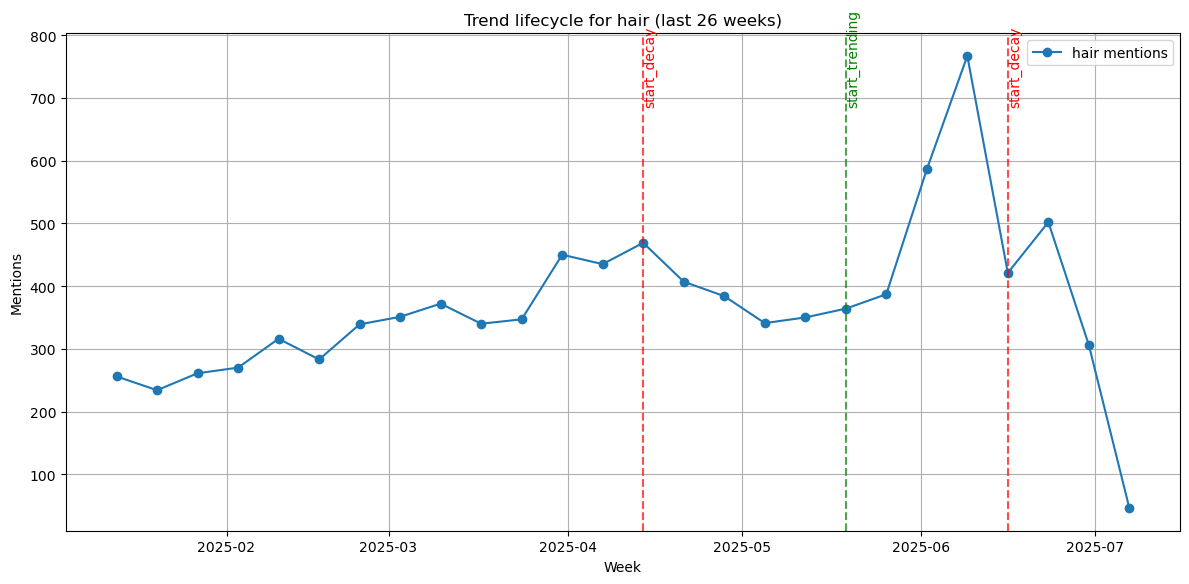

Hair phases: [(Timestamp('2025-05-19 00:00:00'), 'start_trending'), (Timestamp('2025-04-14 00:00:00'), 'start_decay'), (Timestamp('2025-06-16 00:00:00'), 'start_decay')]


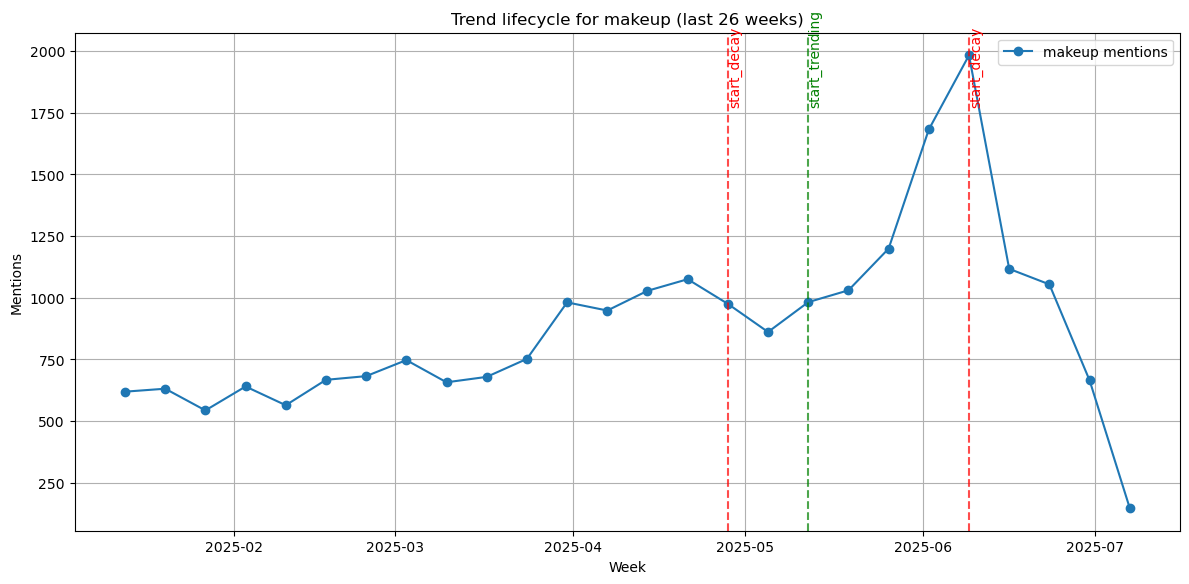

Makeup phases: [(Timestamp('2025-05-12 00:00:00'), 'start_trending'), (Timestamp('2025-04-28 00:00:00'), 'start_decay'), (Timestamp('2025-06-09 00:00:00'), 'start_decay')]


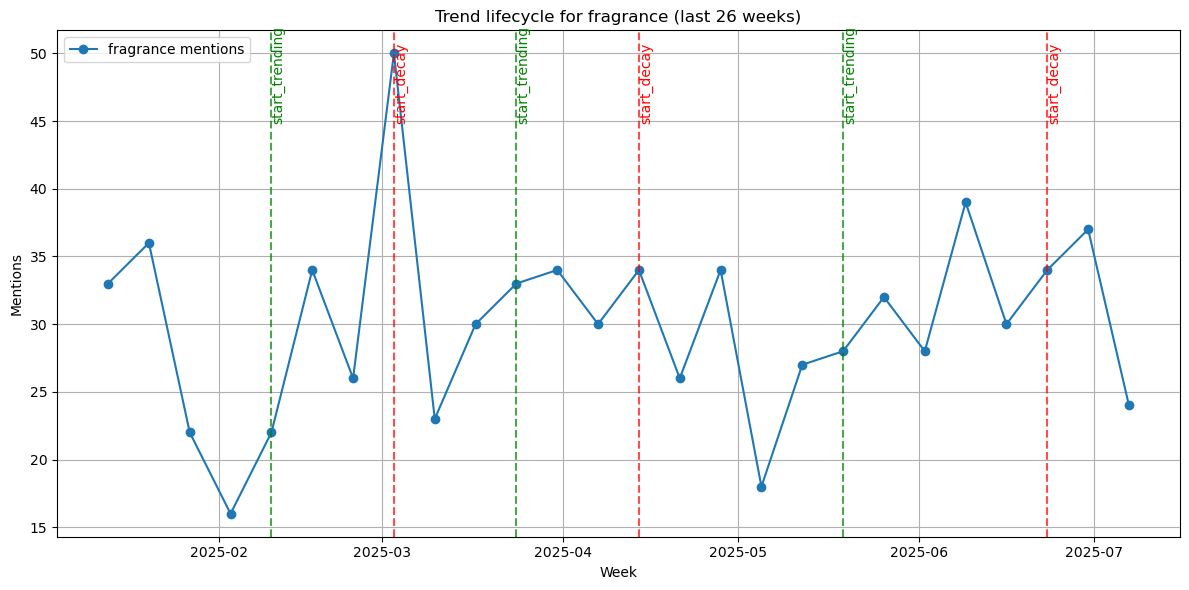

Fragrance phases: [(Timestamp('2025-02-10 00:00:00'), 'start_trending'), (Timestamp('2025-03-24 00:00:00'), 'start_trending'), (Timestamp('2025-05-19 00:00:00'), 'start_trending'), (Timestamp('2025-03-03 00:00:00'), 'start_decay'), (Timestamp('2025-04-14 00:00:00'), 'start_decay'), (Timestamp('2025-06-23 00:00:00'), 'start_decay')]


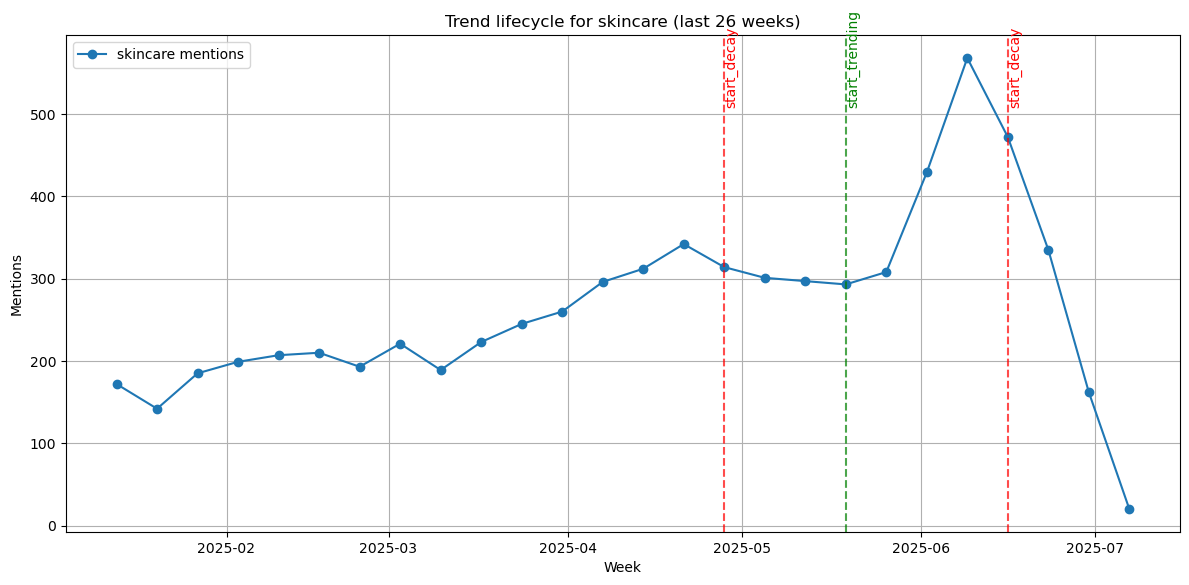

Skincare phases: [(Timestamp('2025-05-19 00:00:00'), 'start_trending'), (Timestamp('2025-04-28 00:00:00'), 'start_decay'), (Timestamp('2025-06-16 00:00:00'), 'start_decay')]


In [351]:
# Suppose you already have fam_weekly = DataFrame(["week","family","count"])

# Check for hair family
phases_hair = plot_family_with_phases(fam_weekly, "hair", lookback=26)
print("Hair phases:", phases_hair)

# Check for makeup family
phases_makeup = plot_family_with_phases(fam_weekly, "makeup", lookback=26)
print("Makeup phases:", phases_makeup)

# Check for fragrance family
phases_fragrance = plot_family_with_phases(fam_weekly, "fragrance", lookback=26)
print("Fragrance phases:", phases_fragrance)

# Check for skincare family
phases_skincare = plot_family_with_phases(fam_weekly, "skincare", lookback=26)
print("Skincare phases:", phases_skincare)

## Intepretation:

- Hair → Grew steadily, peaked strongly in June, then started to fall.
- Makeup → Very sharp rise into June, but quickly declined afterward.
- Fragrance → Mostly flat, with small ups and downs (no strong trend).
- Skincare → Gradual growth until June, peaked, and then dropped.

Overall: **Hair and Skincare** had steady builds before peaking, **Makeup** spiked and collapsed fast, while **Fragrance** stayed stable with no big movement.

C:\Users\lunwe\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/157 [00:00<?, ?it/s]


Cluster 0 top words:
[('to', 2750), ('makeup', 2709), ('for', 2521), ('and', 2507), ('the', 1962), ('beauty', 1308), ('a', 1184), ('of', 1129), ('#shorts', 1106), ('-', 1105), ('in', 1049), ('face', 1022), ('with', 1021), ('skin', 1015), ('your', 1009), ('you', 966), ('my', 859), ('look', 845), ('#makeup', 825), ('|', 816)]

Cluster 1 top words:
[('hair', 2564), ('for', 945), ('to', 786), ('and', 748), ("'hair", 581), ('the', 569), ('with', 450), ('a', 434), ('you', 380), ('in', 371), ('#shorts', 364), ('your', 361), ('#hair', 334), ('color', 326), ('my', 326), ('#hairstyle', 284), ('on', 282), ("hair',", 282), ('of', 273), ('|', 269)]


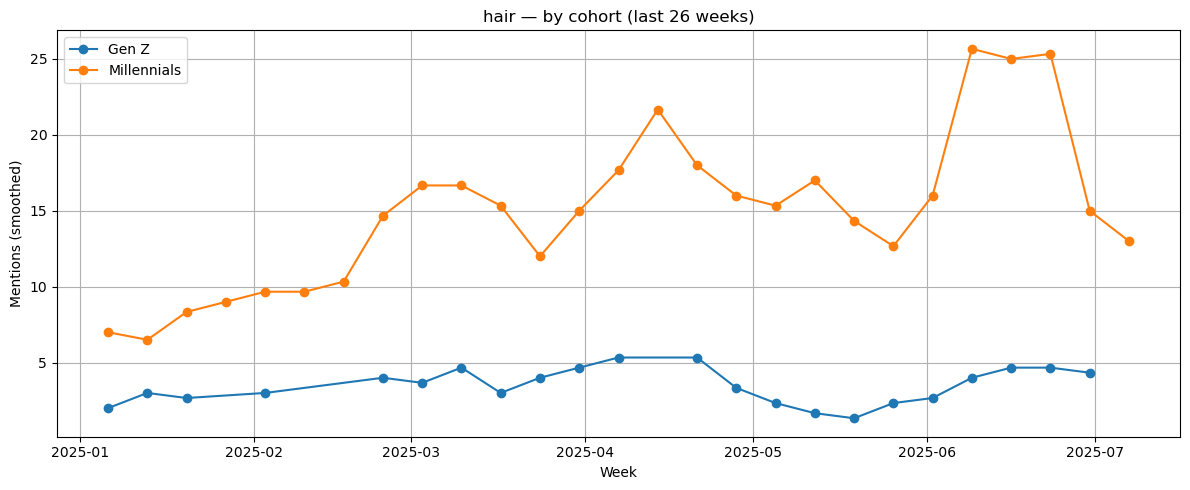

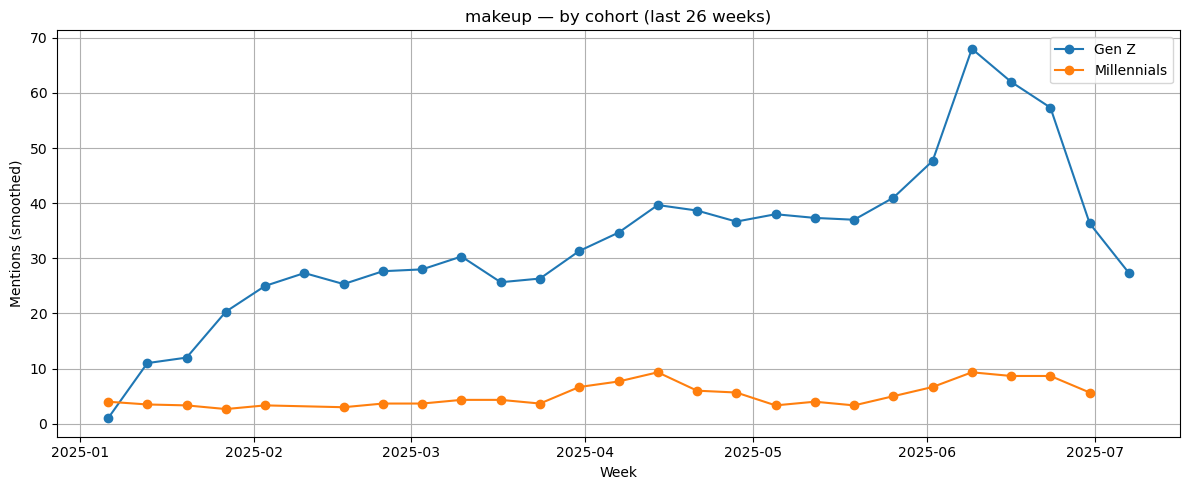

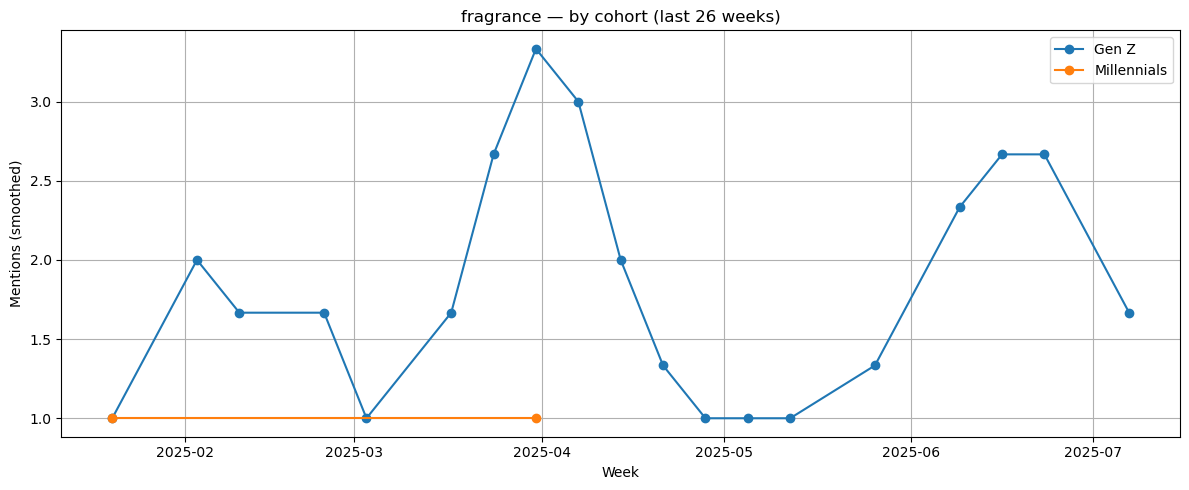

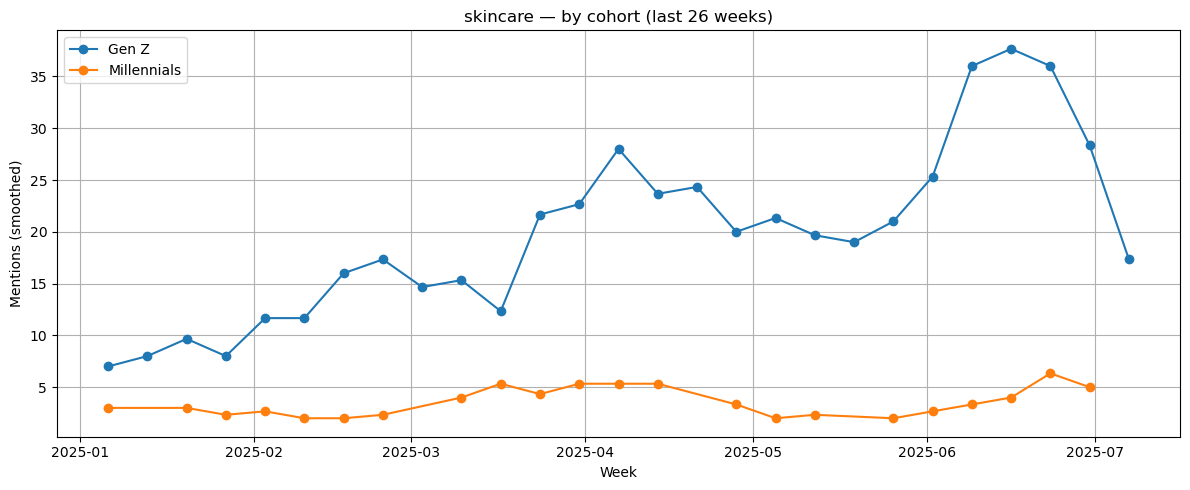

In [149]:
# =========================
# TrendSpotter — Cohort View (Gen Z vs Millennials proxy)
# =========================
from collections import Counter

# --- 1) Prepare combined text for embeddings ---
df["text_combined"] = df[["title","description","tags"]].astype(str).agg(" ".join, axis=1)

# Optional: sample subset if dataset is huge (to save time)
sample_df = df.sample(5000, random_state=42) if len(df) > 5000 else df.copy()
texts = sample_df["text_combined"].tolist()

# --- 2) Generate embeddings ---
model = SentenceTransformer("all-MiniLM-L6-v2")   # small, fast model
embeddings = model.encode(texts, show_progress_bar=True)

# --- 3) Cluster into 2 groups (Gen Z vs Millennials proxy) ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(embeddings)
sample_df["cluster"] = labels

# --- 4) Inspect clusters to label them ---
for c in range(2):
    cluster_texts = " ".join(
        sample_df[sample_df["cluster"]==c]["text_combined"].tolist()
    ).lower().split()
    common = Counter(cluster_texts).most_common(20)
    print(f"\nCluster {c} top words:")
    print(common)

# --- 5) Map cluster → cohort (adjust after inspection) ---
sample_df["cohort"] = sample_df["cluster"].map({0:"Gen Z", 1:"Millennials"})

# --- 6) Attach cohort labels back to main df safely ---
cohort_map = sample_df.set_index("videoId")["cohort"].to_dict()
df["cohort"] = df["videoId"].map(cohort_map).fillna("Unlabeled")
df = df[df["cohort"]!="Unlabeled"].copy()

# --- 7) Ensure 'family' exists (reuse FAMILIES dict from Family view) ---
if "family" not in exploded.columns:
    TOKEN2FAM = {t: fam for fam, ts in FAMILIES.items() for t in ts}
    exploded["family"] = exploded["token"].str.lower().map(lambda t: TOKEN2FAM.get(t, "other"))

# --- 8) Weekly counts by cohort & family ---
wk_cohort_family = (
    exploded.merge(df[["videoId","cohort"]], on="videoId", how="left")
            .groupby(["week","cohort","family"]).size()
            .reset_index(name="count")
)

# --- 9) Plot helper ---
def plot_family_by_cohort(wk, family, last_weeks=26):
    sub = wk[wk["family"]==family].copy()
    if sub.empty:
        print(f"No data for family '{family}'")
        return
    end = sub["week"].max()
    start = end - pd.Timedelta(weeks=last_weeks)
    sub = sub[(sub["week"]>=start)&(sub["week"]<=end)]
    
    plt.figure(figsize=(12,5))
    for coh, g in sub.groupby("cohort"):
        g = g.sort_values("week")
        plt.plot(g["week"], g["count"].rolling(3, min_periods=1).mean(),
                 marker="o", label=str(coh))
    plt.title(f"{family} — by cohort (last {last_weeks} weeks)")
    plt.xlabel("Week"); plt.ylabel("Mentions (smoothed)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- 10) Example: plot cohort split for key families ---
for fam in ["hair","makeup","fragrance","skincare"]:
    plot_family_by_cohort(wk_cohort_family, family=fam, last_weeks=26)


# 📊 Final Takeaways & Actions for L’Oréal

Our analysis shows that **short-form video** (TikTok, IG Reels, YouTube Shorts) is the key driver of beauty conversations, especially among **Gen Z**.  
Millennials are more stable in traditional categories like **hair**, while Gen Z dominates **makeup** and **skincare**.

---

## 1. Hair (Millennials-led, but Decaying)
**Observation:** Hair conversations peaked with transformations and cuts but are now cooling.  
Millennials dominate, while Gen Z shows weaker participation.  

**Action:**  
- For Millennials → Frame hair content as **confidence-boosting transformations** with a nostalgic twist.  
- For Gen Z → Repackage into **short-form challenges** (e.g., TikTok before-after trends, hybrid GRWM + hair hacks).  
- Cross-link hair with **skincare/makeup routines** to keep relevance.  

---

## 2. Makeup (Gen Z Powerhouse, but Cooling Down)
**Observation:** Makeup is the **anchor category for Gen Z** (tutorials, GRWM, lipstick).  
Growth has slowed but remains strong. Skincare is often linked via GRWM routines.  

**Action:**  
- Scale **creator-led short-form tutorials** to maintain momentum.  
- Use **AI/AR try-on tools** to deepen digital engagement.  
- Launch **limited seasonal drops** (lipsticks, palettes) to reignite hype.  

---

## 3. Skincare (Gen Z Growth Driver, Still Rising)
**Observation:** Skincare is **consistently rising among Gen Z**, tied to self-care, glow, and GRWM routines.  
Millennials engage less but steadily.  

**Action:**  
- Position skincare as **daily ritual content** (e.g., “morning reset,” “night reset”).  
- Lean into **ingredient education + authentic creators** to build trust.  
- Bundle skincare with makeup (GRWM) and fragrance (“glow + scent”) for crossover appeal.  

---

## 4. Fragrance (Low Volume, Emerging in Gen Z)
**Observation:** Still a small category, but Gen Z shows **growing curiosity**; Millennials nearly absent.  

**Action:**  
- Push **storytelling-driven short videos** connecting fragrance to **identity, emotions, and mood**.  
- Bundle with skincare or makeup to **ride on higher-volume categories**.  
- Frame as **luxury but accessible** — an entry point into L’Oréal.  

---

## ✅ Strategic Implications
- **Short-term:** Hair (Millennials) → sustain via **transformation campaigns + TikTok hybrids**.  
- **Long-term anchors:** Makeup & Skincare (Gen Z) → double down on **tutorials, GRWM, AR try-ons** in short-form video.  
- **Emerging:** Fragrance (Gen Z niche) → build **identity storytelling** and bundle with skincare/makeup for discovery.  


## CSV Export: For Streamlit APP

In [102]:
# 📤 Export processed tables for Streamlit app

# 1. Hybrid Monthly
hybrid_monthly_fair.to_csv("hybrid_monthly.csv", index=False)

# 2. Hybrid Sustained
hybrid_sustained_fair.to_csv("hybrid_sustained.csv", index=False)

# 3. Family Weekly Counts
fam_weekly.to_csv("fam_weekly.csv", index=False)

# 4. Cohort + Family Weekly Counts
wk_cohort_family.to_csv("wk_cohort_family.csv", index=False)

print("✅ Export complete! Files saved as:")
print("- hybrid_monthly.csv")
print("- hybrid_sustained.csv")
print("- fam_weekly.csv")
print("- wk_cohort_family.csv")


✅ Export complete! Files saved as:
- hybrid_monthly.csv
- hybrid_sustained.csv
- fam_weekly.csv
- wk_cohort_family.csv
